# Initialization

In [5]:
%matplotlib widget

In [17]:
%matplotlib inline

In [7]:
#%ls /afs/cern.ch/eng/lhc/optics/runIII/RunIII_dev/2021_V6/PROTON/

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Make sure this import is after pandas
import Backend.Constants as cst
import Backend.NXCALS as nx
import twissExtractor

# Importing data
database = pd.read_parquet('Data_merged/dataset_2022_05_22.parquet')
database.insert(0,'Time',(database.index - database.index[0]).total_seconds())

MDWindow = [pd.Timestamp('2022-05-22 13:30'),pd.Timestamp('2022-05-22 16:45')]
MDTime = (MDWindow[1]-MDWindow[0]).total_seconds()

#locations = ['L1B1','R1B2','L5B1','R5B2']
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]
lineInfo  = [('b','-v'),('r','-v'),('b','-^'),('r','-^')]




# Grouping data into ON-current phases for both B1 and B2
#=========================================================
phase_list= {'B1:1': [pd.Timestamp('2022-05-22 13:30')   ,pd.Timestamp('2022-05-22 14:11')],
             'B1:2': [pd.Timestamp('2022-05-22 15:03')   ,pd.Timestamp('2022-05-22 15:17')],
             'B1:3': [pd.Timestamp('2022-05-22 15:41')   ,pd.Timestamp('2022-05-22 16:06')],
             'B2:1': [pd.Timestamp('2022-05-22 14:12')   ,pd.Timestamp('2022-05-22 14:43')],
             'B2:2': [pd.Timestamp('2022-05-22 15:18')   ,pd.Timestamp('2022-05-22 15:35')],
             'B2:3': [pd.Timestamp('2022-05-22 16:09:30'),pd.Timestamp('2022-05-22 16:30')]
            }

if 'Phase' not in database.columns:
    database.insert(1,'Phase','None')
    for name,_window in phase_list.items():
        cutting = pd.cut(database.index,bins=_window)

        database.loc[list(database.groupby(cutting).get_group(cutting.categories[0]).index),'Phase']  = name
#==========================================================



if True:

    #============================
    # finding beta function @ wire
    twiss = twissExtractor.fromOptics('opticsfile.1')

    for beam in beams:
        for wire in wires[beam.name]:
            _twissLoc  = [name for name in twiss[beam.name].index if ('bbcw' in name)&(wire.loc[:2].lower() in name)]
            upstream   = [name for name in _twissLoc if '.u.' in name][0]
            downstream = [name for name in _twissLoc if '.d.' in name][0]

            # Averaging beta upstream and downstream
            betx,bety = twiss[beam.name].loc[[upstream,downstream],['betx','bety']].mean()

            # Finding wire length
            #L = np.max(np.abs(twiss[beam.name].loc[[upstream,downstream],['s']].diff()))[0]
            L = 1

            # Attaching to wire class
            wire.betx = betx
            wire.bety = bety
            wire.L    = L

else:
    
    default_twiss= {'L1B1':(163.3798836266144 , 81.5488800490455),
                    'L5B1':(166.41256005446527, 81.32733919958042),
                    'R1B2':(163.37992365633735, 81.54888202620587),
                    'R5B2':(166.41255061212124, 81.32733792781474)}
    
    for beam in beams:
        for wire in wires[beam.name]:
            betx,bety = default_twiss[wire.loc]
            
            # Attaching to wire class
            wire.betx = betx
            wire.bety = bety
            wire.L    = 1



In [ ]:
for beam in beams:
    for wire in wires[beam.name]:
        print(wire.loc,wire.betx,wire.bety,wire.L)

In [ ]:
np.max(database[wire['I']])

### Tune VS Current

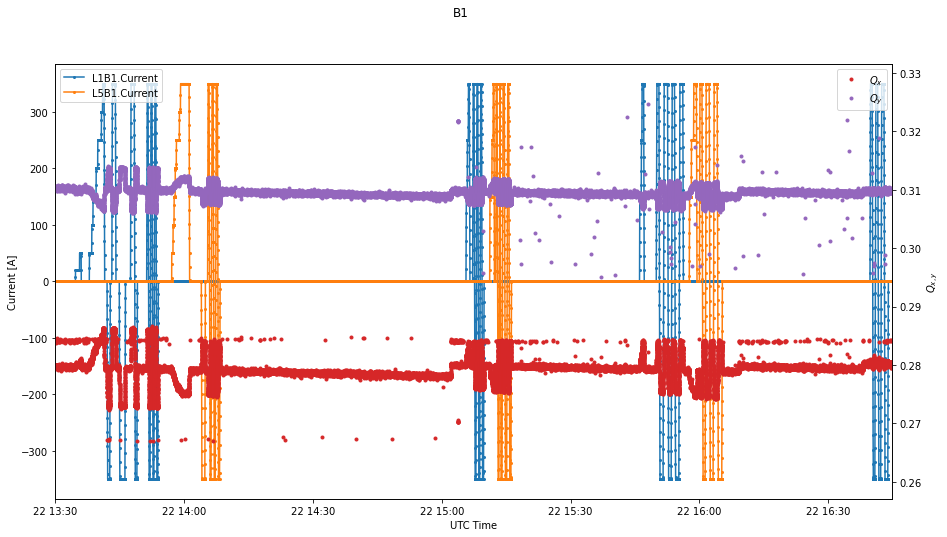

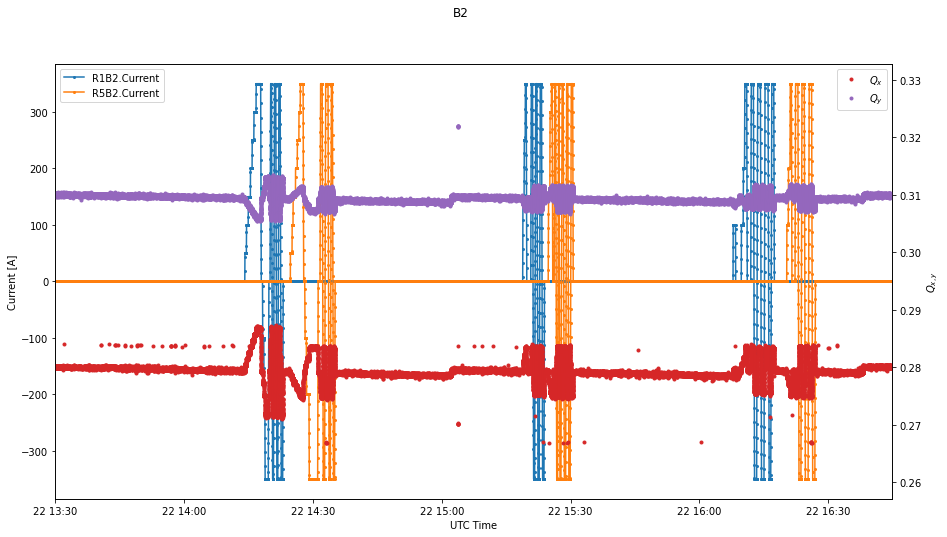

In [19]:



for beam in beams:
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(beam.name)
    
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        database.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        
    ax2 = plt.gca().twinx()
    plt.sca(ax2)
    database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


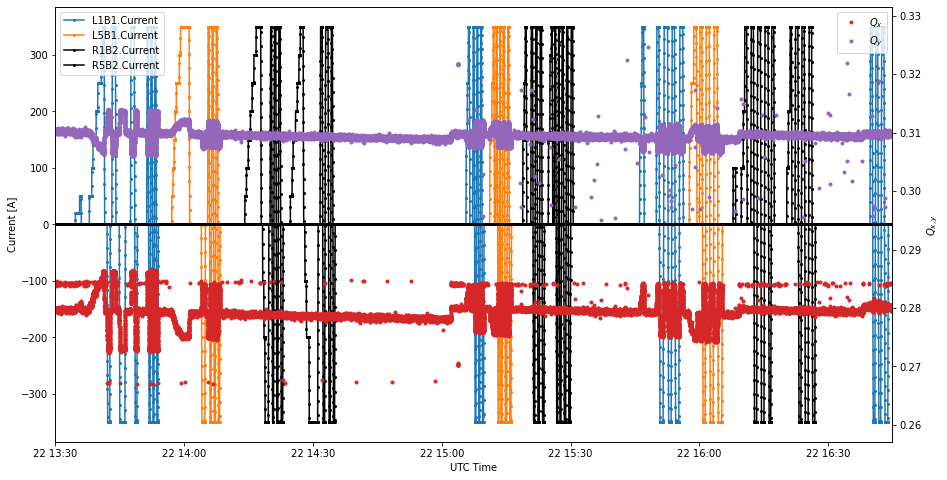

In [20]:



plt.figure(figsize=(15, 8))

ax1 = plt.gca()
ax2 = plt.gca().twinx()
    
for beam in beams:
    
    
    plt.sca(ax1)
    
    for wire,color in zip(wires[beam.name],['C0','C1']):
        if beam.name == 'B2':
            color = 'k'
        database.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        

    plt.sca(ax2)
    if beam.name == 'B2':
        pass
    else:
        database.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
        database.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])
    

    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)
    
    


### Reconstructing Tune shift

In [ ]:
#%matplotlib widget

2.298e-04
6.102e-04
1.376e-04
4.704e-04
3.843e-04
2.666e-04
1.896e-04
1.889e-04
1.462e-04
2.761e-04
1.800e-04
1.763e-04


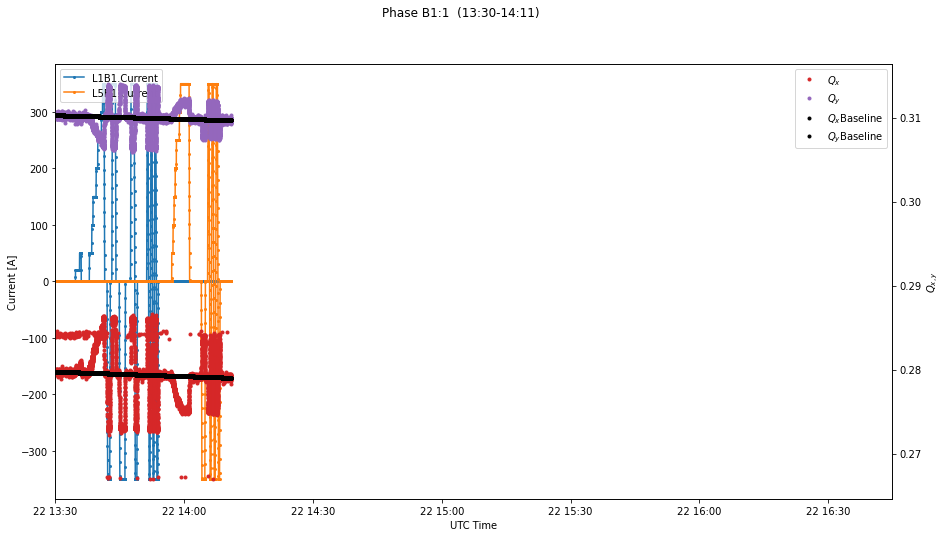

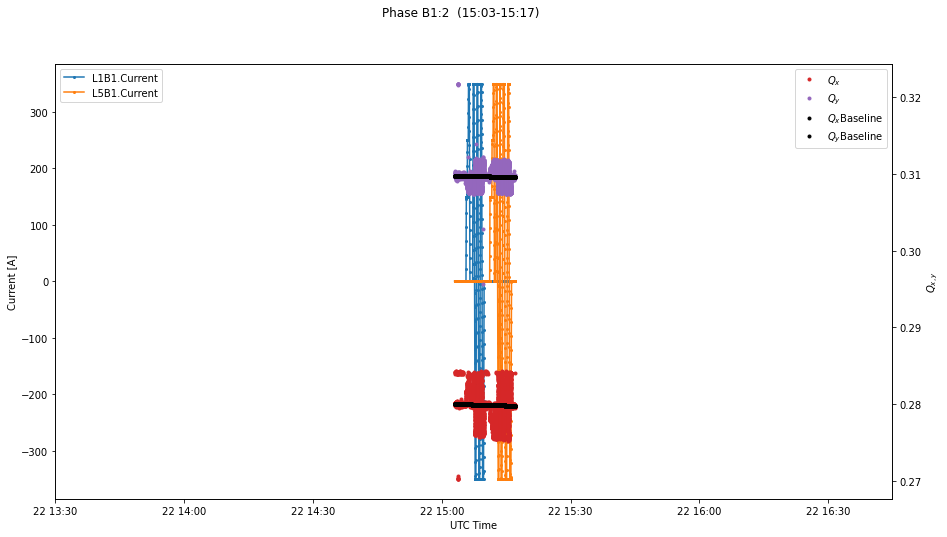

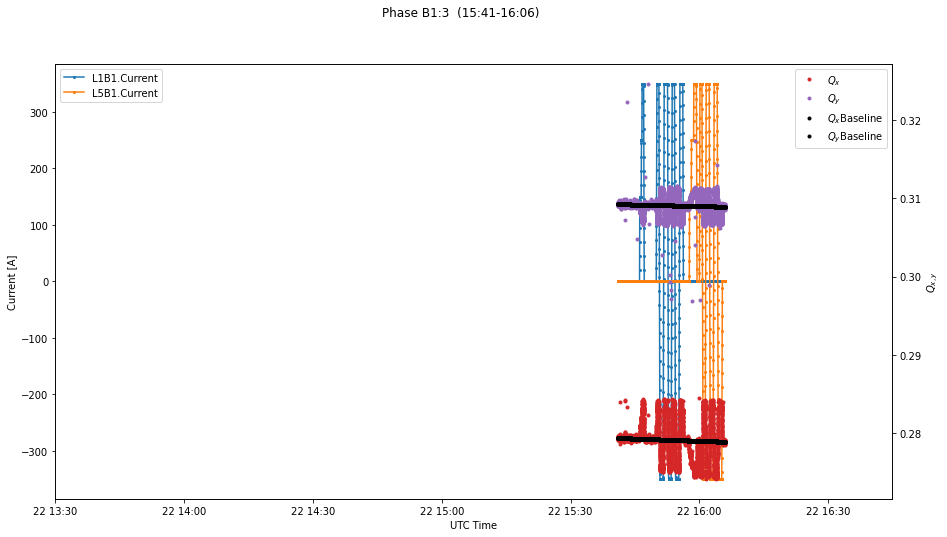

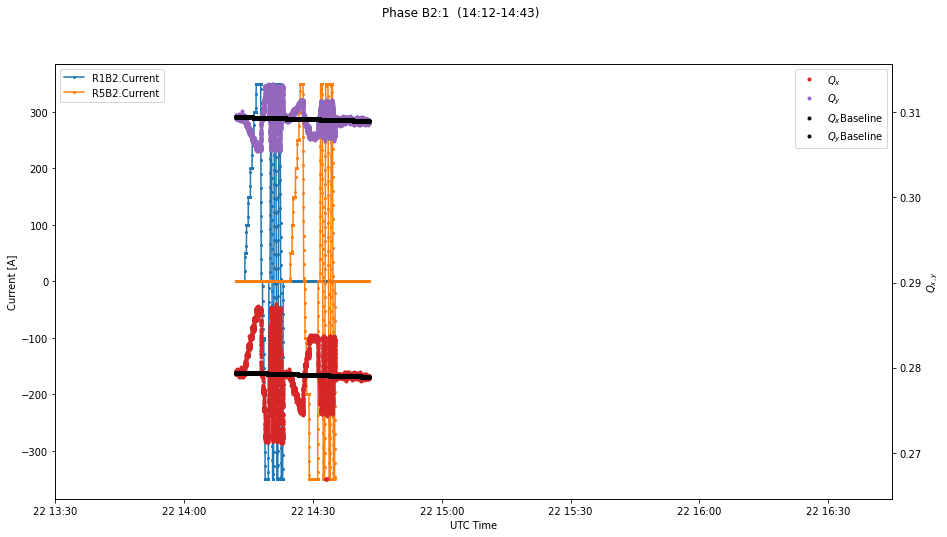

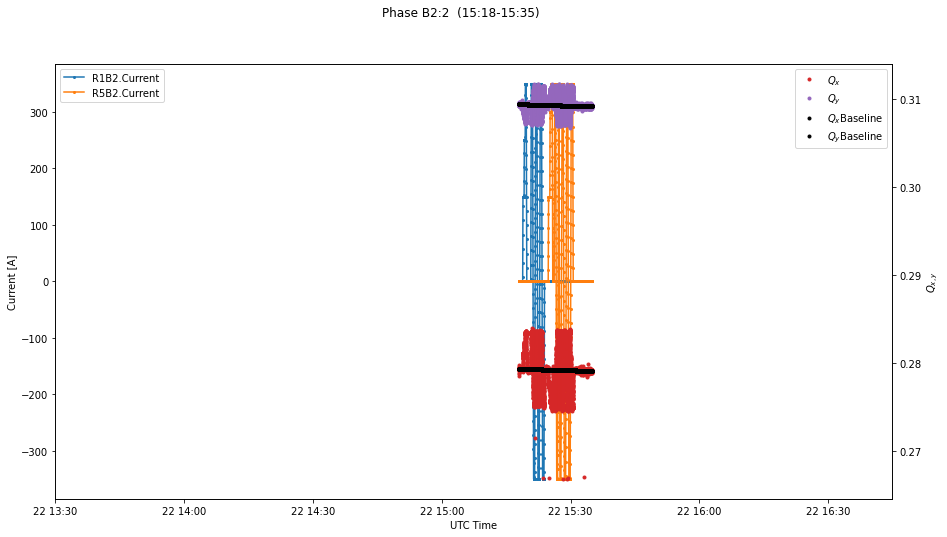

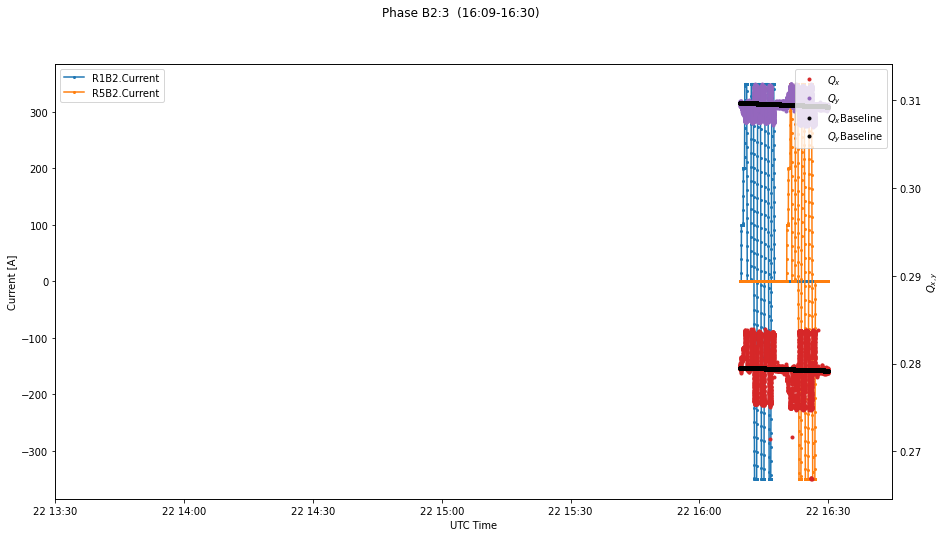

In [21]:



grouped = database.groupby('Phase')

for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]

    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']

    # Finding location of ON/OFF current
    ON_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                    group.dropna(subset=[wire1['I']])[wire1['I']])

    ON_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                    group.dropna(subset=[wire2['I']])[wire2['I']])

    # Setting values to 0 or 1
    ON_wire1[np.abs(ON_wire1)<0.1] = 0
    ON_wire2[np.abs(ON_wire2)<0.1] = 0
    #-----
    ON_wire1[np.abs(ON_wire1)>0.1] = 1
    ON_wire2[np.abs(ON_wire2)>0.1] = 1


    # Keeping only values when both are off
    ON_baseline = np.invert(ON_wire1.astype(bool))*np.invert(ON_wire2.astype(bool))



    def baseline(t,a,b):
        return a*t+b


    t  = tuneTimes[ON_baseline]
    for tune in [beam['Qy_HS'],beam['Qx_HS']]:
        if tune+'_baseline' not in database.columns:
            database.insert(2,tune+'_baseline',np.nan)
            database.insert(3,tune+'_shift',np.nan)

        Q = subset[tune][ON_baseline]

        cutoff = 4*np.std(Q)
        print(f'{np.std(Q):.3e}')
        outliers = np.abs(Q-np.mean(Q))>cutoff

        popt, pcov = curve_fit(baseline, t[~outliers],Q[~outliers])

        database.loc[tuneIndex,tune+'_baseline'] = baseline(tuneTimes,*popt)
        database.loc[tuneIndex,tune+'_shift']    = subset[tune] - baseline(tuneTimes,*popt)

        
        
grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0] 
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)

    group.nxPlot('index',beam['Qx_HS'],'.',color='C3',label = beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS'],'.',color='C4',label = beam.label['Qy_HS'])

    group.nxPlot('index',beam['Qx_HS']+'_baseline','.',color='k',label = beam.label['Qx_HS']+'Baseline')
    group.nxPlot('index',beam['Qy_HS']+'_baseline','.',color='k',label = beam.label['Qy_HS']+'Baseline')


    plt.legend(loc='upper right')
    plt.ylabel(r'$Q_{x,y}$')
    plt.xlim(MDWindow)


# Plotting tune shift

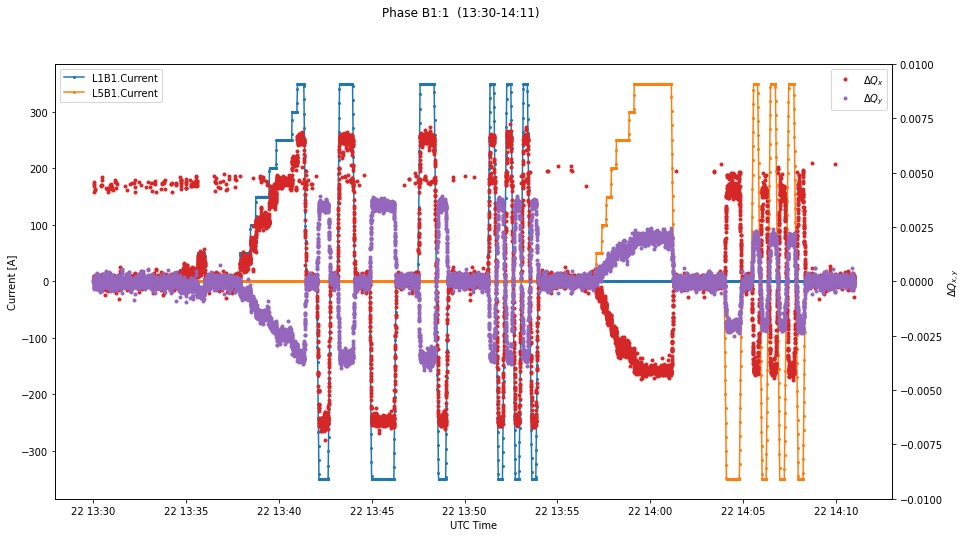

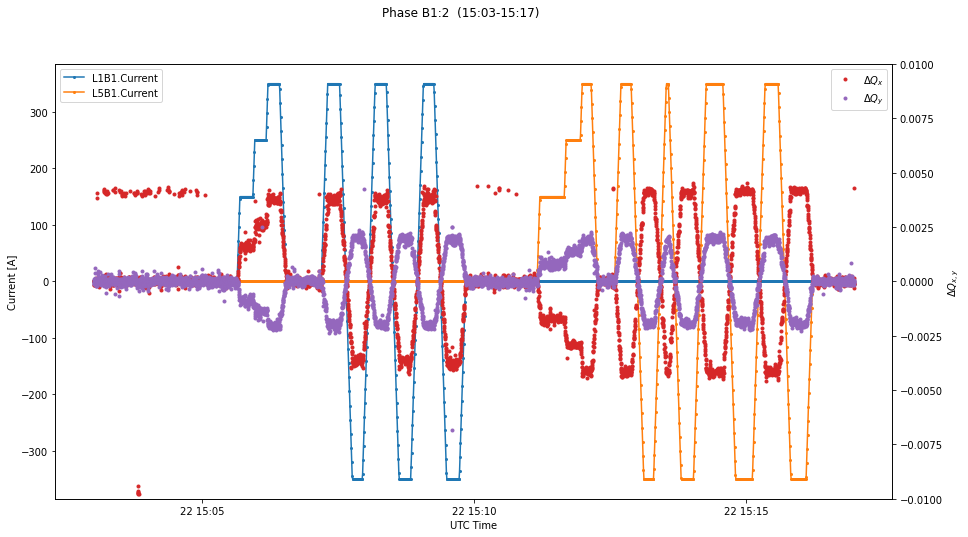

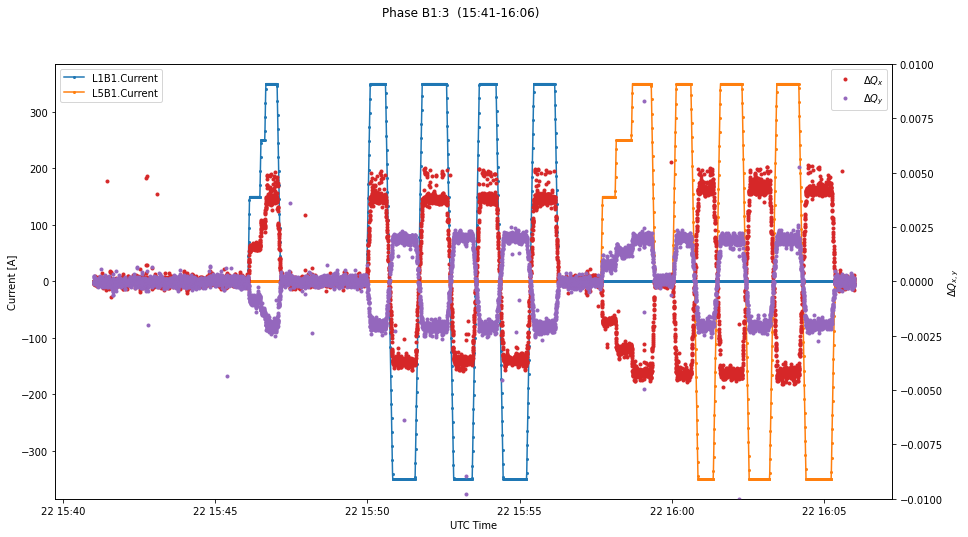

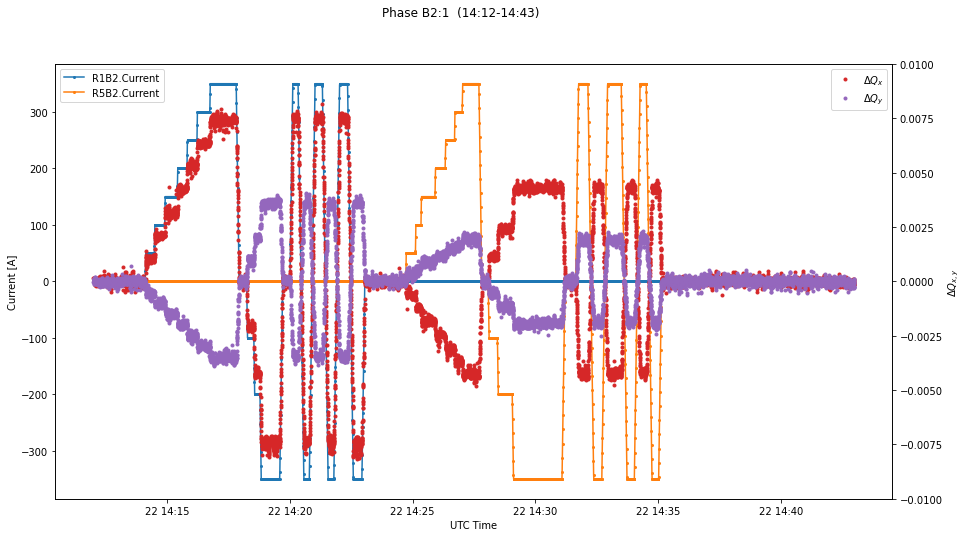

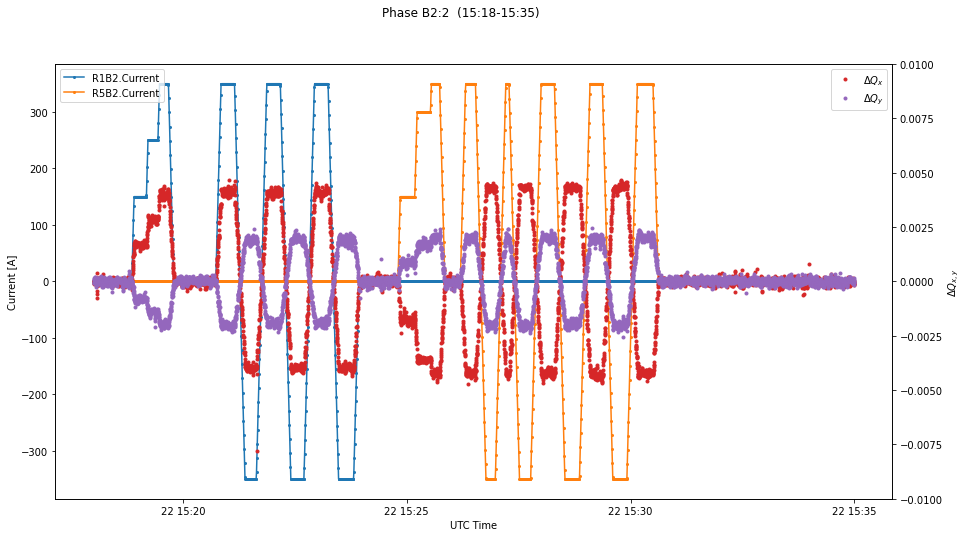

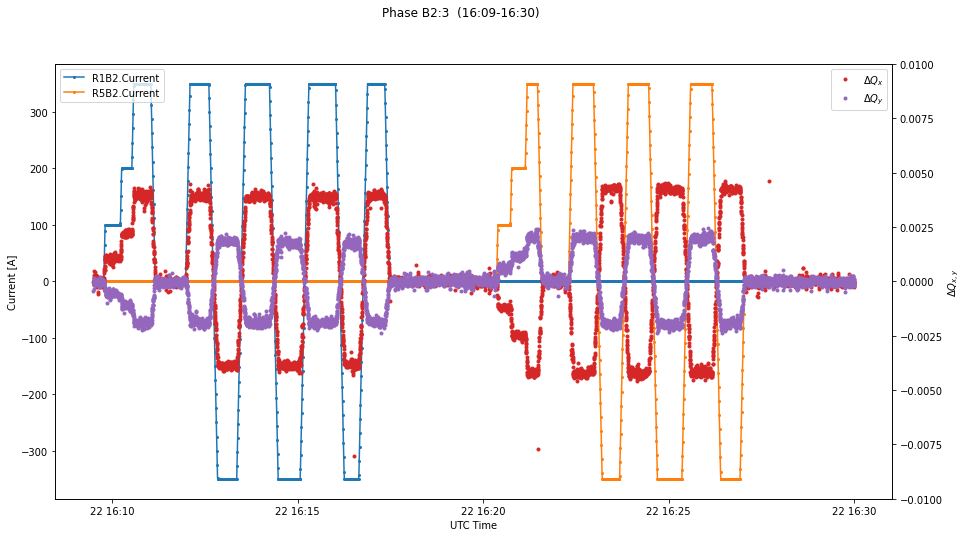

In [22]:


grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam 
    beam = [beam for beam in beams if beam.name in name][0]  
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    # Plot current in wire
    for wire,color in zip(wires[beam.name],['C0','C1']):
        group.nxPlot('index',wire['I'],'-o',color=color,ms=2,label = wire.loc + '.' + wire.label['I'])

    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")


    ax2 = plt.gca().twinx()
    plt.sca(ax2)


    group.nxPlot('index',beam['Qx_HS']+'_shift','.',color='C3',label = r'$\Delta$'+beam.label['Qx_HS'])
    group.nxPlot('index',beam['Qy_HS']+'_shift','.',color='C4',label = r'$\Delta$'+beam.label['Qy_HS'])
    plt.ylim([-0.01,0.01])

    plt.legend(loc='upper right')
    plt.ylabel(r'$\Delta Q_{x,y}$')
    #plt.xlim(MDWindow)
    
    

# Tune Shift vs current

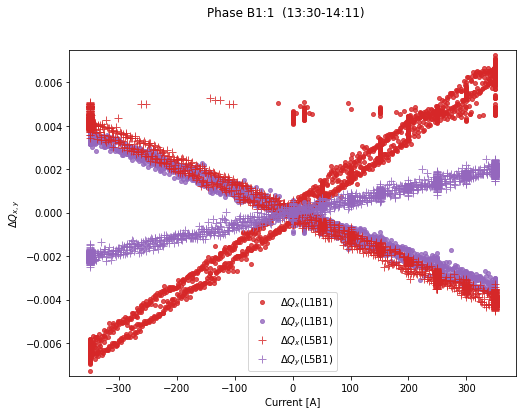

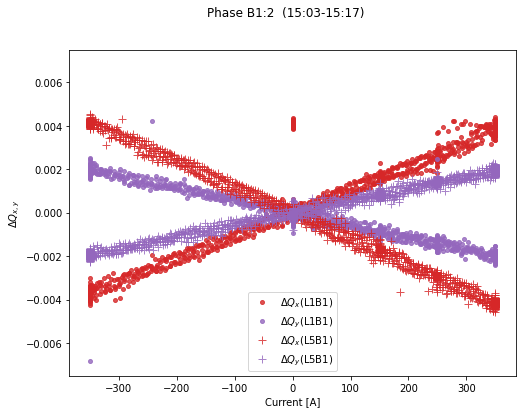

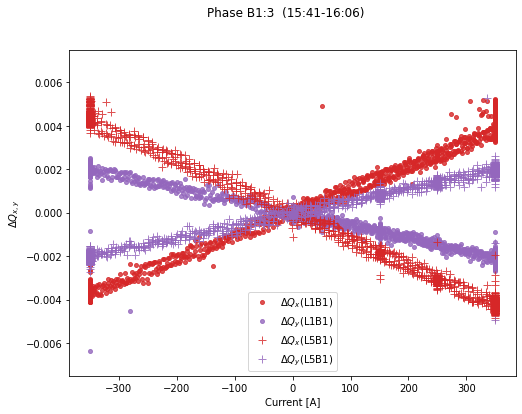

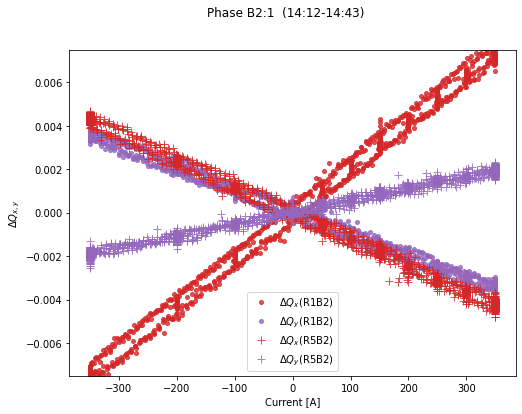

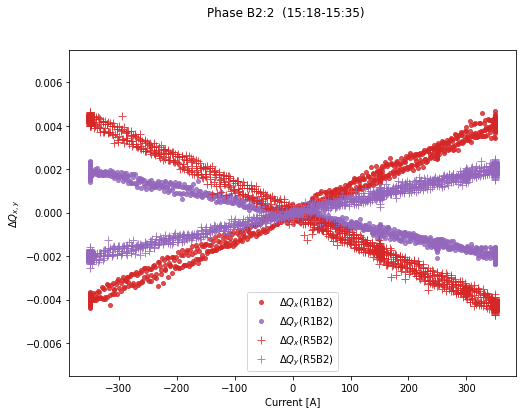

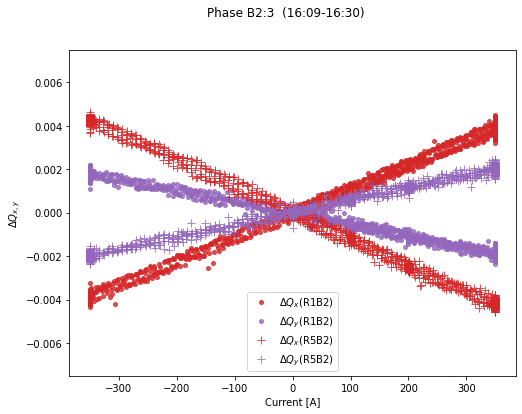

In [23]:



grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(8, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    plt.plot(I_wire1[on_wire1],DQx[on_wire1],'.',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire1.loc})')
    plt.plot(I_wire1[on_wire1],DQy[on_wire1],'.',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire1.loc})')
    
    plt.plot(I_wire2[on_wire2],DQx[on_wire2],'+',ms=8,alpha=0.8,color='C3',label=r'$\Delta Q_x$' + f'({wire2.loc})')
    plt.plot(I_wire2[on_wire2],DQy[on_wire2],'+',ms=8,alpha=0.8,color='C4',label=r'$\Delta Q_y$' + f'({wire2.loc})')
    
    plt.legend()
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    
    

# Looking at collimator Gap

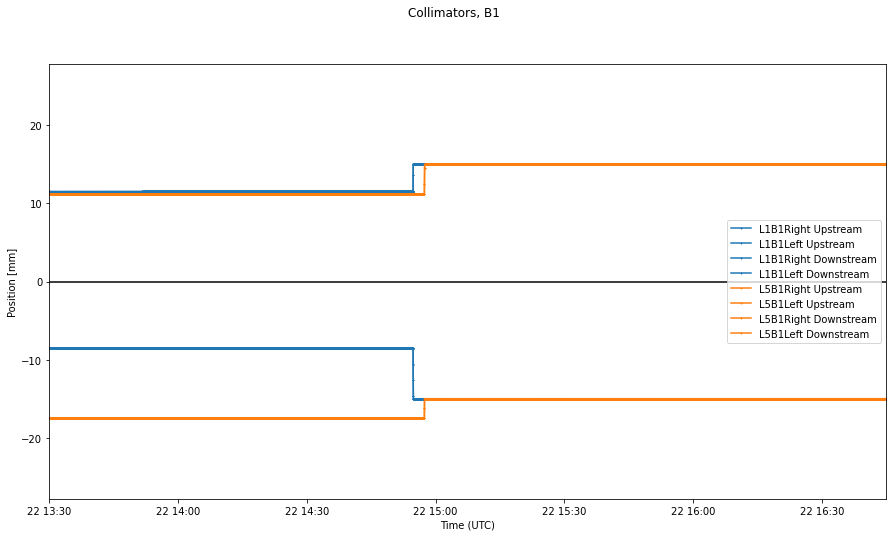

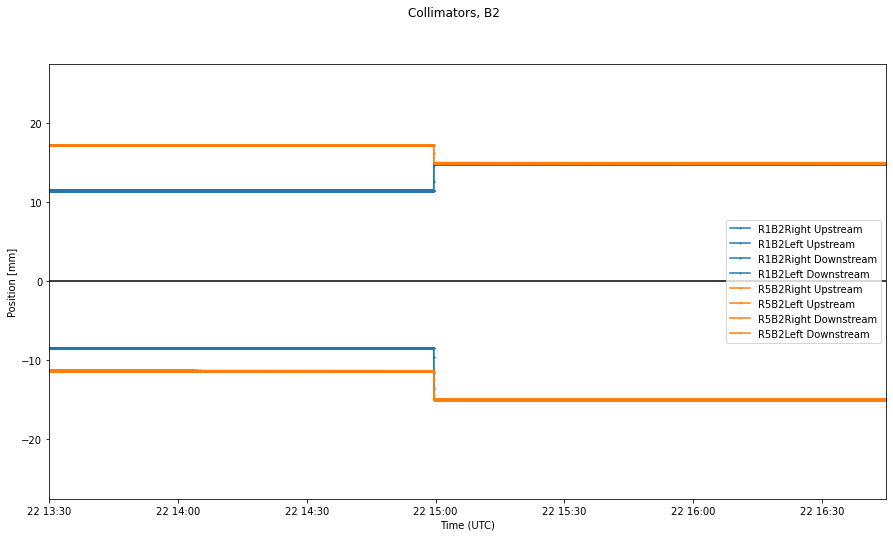

In [24]:


for beam in beams:
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Collimators, ' + beam.name)
    for wire,color in zip(wires[beam.name],['C0','C1']):
        for pos,var in wire.Position.items():
            database.nxPlot('index',var,'-+',color=color,ms=2,label = wire.loc+pos)
    plt.axhline(0,color='k')
    plt.legend()
    plt.ylabel(f"{wire.label['Position']} [{wire.units['Position']}]")
    plt.xlabel(r'Time (UTC)')
    plt.xlim(MDWindow)


# 5th axis alignment

Let's focus on phases 2-3 for now since the collimator settings are symmetric.

In the double wire configuration, the wires might be misaligned with regard to the beam. That is, in IP1 (vertical crossing), the two wires will be centered in the vertical plane, but might be misaligned on the horizontal plane. Starting from the multipolar expansion:


$$\begin{aligned} K_{N_n} + iK_{S_n} = -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \frac{n!}{\left(r_w e^{i\phi_w}\right)^{n+1}}  \end{aligned}$$

and assuming that the two wires are at an angle $\pm\phi_w$ with regard to the beam, one finds:

$$\begin{aligned} K_{N_n} + iK_{S_n} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{e^{-i(n+1)\phi_w} + e^{i(n+1)\phi_w}}{r_w^{n+1}} \right]n!\\
\sum_n \frac{K_{N_n} + iK_{S_n}}{n!} &= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\overbrace{\frac{2\cos(\phi_w)}{r_w}}^{\text{Dipole}}
+ \overbrace{\frac{2\cos(2\phi_w)}{r_w^2}}^{\text{Quad.}}
+ \overbrace{\frac{2\cos(3\phi_w)}{r_w^3}}^{\text{Sext.}}
+ \overbrace{\frac{2\cos(4\phi_w)}{r_w^4}}^{\text{Octu.}}
+\dots\right]\end{aligned}$$

In the case where $\pm \phi_w = \pm \pi/2$, the odd multipoles are cancelled out, but this is not the case otherwise. The tune shift from the quadrupolar and octupolar contribution is :

$$\begin{aligned}\Delta Q_x (J_x, J_y) &= \delta Q_{1,x} + \delta Q_{3,x}(J_x,J_y)\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{2\pi} \left[\frac{1}{4\pi} \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{3}{8\pi}\frac{2\cos(4\phi_w)}{r_w^4}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\\
&= -\frac{1}{B\rho}\frac{\mu_0 (I L)}{8\pi^2} \left[ \frac{2\cos(2\phi_w)}{r_w^2} \beta_x + \frac{2\cos(4\phi_w)}{r_w^4} \frac{3}{2}\Big[\beta_x^2J_x - 2\beta_x\beta_yJ_y\Big]\right]\end{aligned}$$


For the benefit of the Fit, let's rewrite the expected tune shift for on-axis particles as:

$$\Delta Q_x = -\left(\frac{\mu_0 L}{8\pi^2}\frac{ \beta_x}{B\rho}\right) \left[\frac{2\cos(2\phi_w)}{r_w^2}\right]  \cdot I = -\left(\frac{\mu_0 L}{8\pi^2}\frac{ \beta_x}{B\rho}\right)A\cdot I$$

where:
$$A = \frac{2\cos(2\phi_w)}{r_w^2} = \frac{2(x_w^2-y_w^2)}{(x_w^2+y_w^2)^2}$$

In [25]:
#=========================================
# Fitting function
#=========================================
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def dQxdQy(I, xw , yw , betx, bety, Jx = 0 , Jy = 0 ,E = 450e9,L=1):
    rw,phiw = cart2pol(xw, yw)
    
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*(I*L)/(Brho*8*np.pi**2)
    
    quad = 2*np.cos(2*phiw)/rw**2
    octu = 2*np.cos(4*phiw)/rw**4 * (3/2)
    
    dQx  = Q0*( 1*quad*betx + octu*(betx**2*Jx - 2*betx*bety*Jy))
    dQy  = Q0*(-1*quad*bety + octu*(bety**2*Jy - 2*bety*betx*Jx))
    
    return dQx,dQy

def dQxfit(I,A,betx,E = 450e9,L=1):
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*L*betx/(Brho*8*np.pi**2)
    return Q0*A*I

def dQyfit(I,A,bety,E = 450e9,L=1):
    Brho = np.sqrt(E**2-cst.m_p_eV**2)/cst.c
    Q0   = -cst.mu0*L*bety/(Brho*8*np.pi**2)
    return -Q0*A*I

def extractOffset(A,xw=None,yw=None):
    
    if yw is not None:
        pref = np.sqrt(1-4*A*yw**2)/A
        return np.sqrt(-pref + 1/A - yw**2)#,np.sqrt(pref + 1/A - yw**2))
    
    if xw is not None:
        pref = np.sqrt(4*A*xw**2+1)/A
        return np.sqrt(pref - 1/A - xw**2)#(np.sqrt(-pref - 1/A - xw**2),)
    
#==========================================


print(dQxdQy(350, 0     , 12e-3 , 160, 80, E = 450e9,L=1))
print(dQxdQy(350, 12e-3 , 0     , 160, 80, E = 450e9,L=1))

(0.008246787337209788, -0.004123393668604894)
(-0.008246787337209788, 0.004123393668604894)


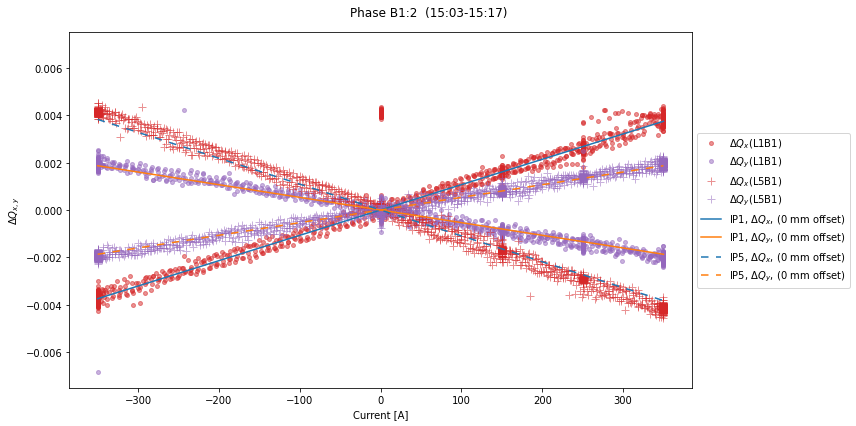

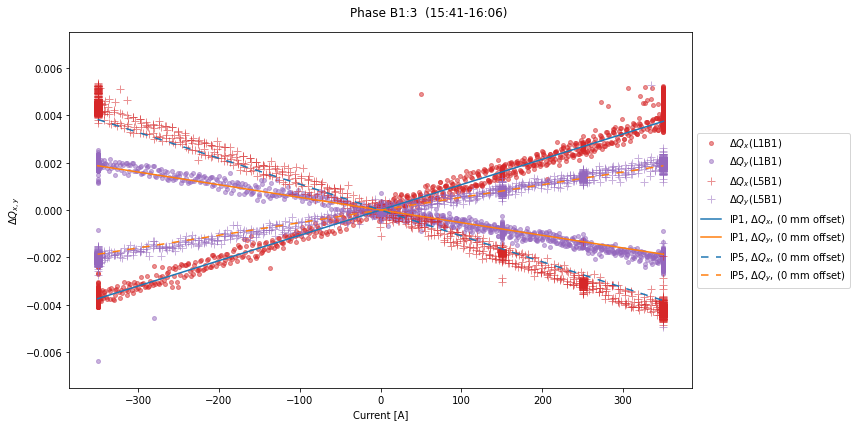

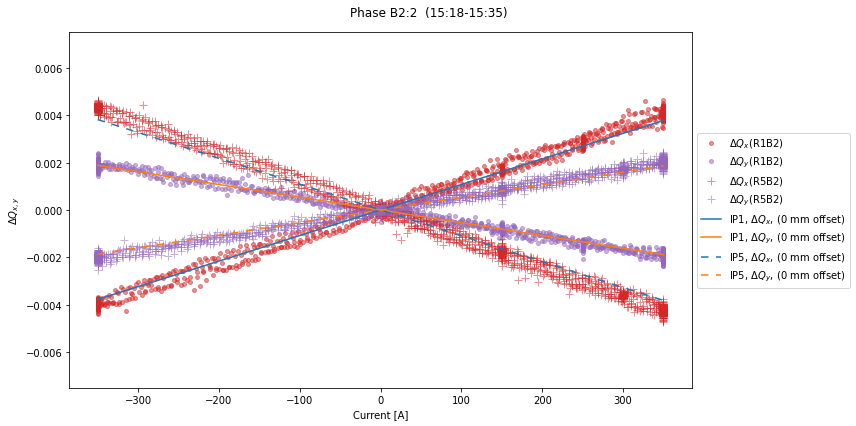

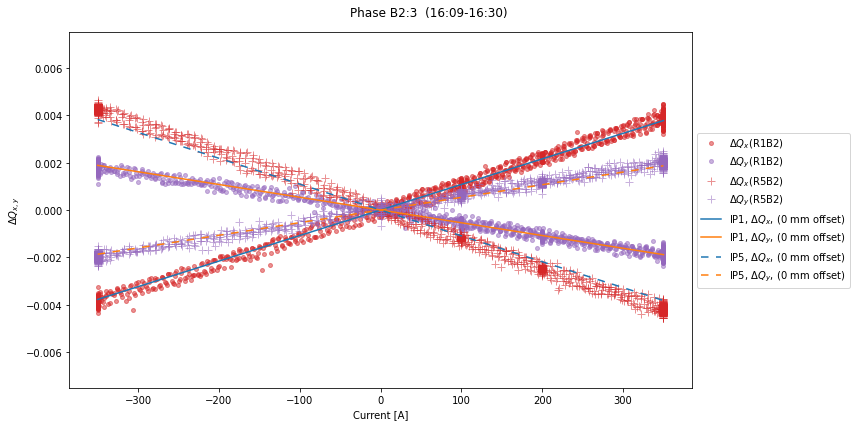

In [26]:


grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    plt.plot(I_wire1[on_wire1],DQx[on_wire1],'.',ms=8,alpha=0.5,color='C3',label=r'$\Delta Q_x$' + f'({wire1.loc})')
    plt.plot(I_wire1[on_wire1],DQy[on_wire1],'.',ms=8,alpha=0.5,color='C4',label=r'$\Delta Q_y$' + f'({wire1.loc})')
    
    plt.plot(I_wire2[on_wire2],DQx[on_wire2],'+',ms=8,alpha=0.5,color='C3',label=r'$\Delta Q_x$' + f'({wire2.loc})')
    plt.plot(I_wire2[on_wire2],DQy[on_wire2],'+',ms=8,alpha=0.5,color='C4',label=r'$\Delta Q_y$' + f'({wire2.loc})')
    
    # Analytic expression
    I_vec = np.linspace(-350,350,100)
    for wire in [wire1,wire2]:
        IP = 'IP' + wire.loc[1]
        
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2 + 3e-3
        
        if IP == 'IP1':
            dQx,dQy = dQxdQy(I_vec,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx,dQy = dQxdQy(I_vec,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        plt.plot(I_vec,dQx,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        plt.plot(I_vec,dQy,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
        
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    plt.tight_layout()
    
    

## With an offset?

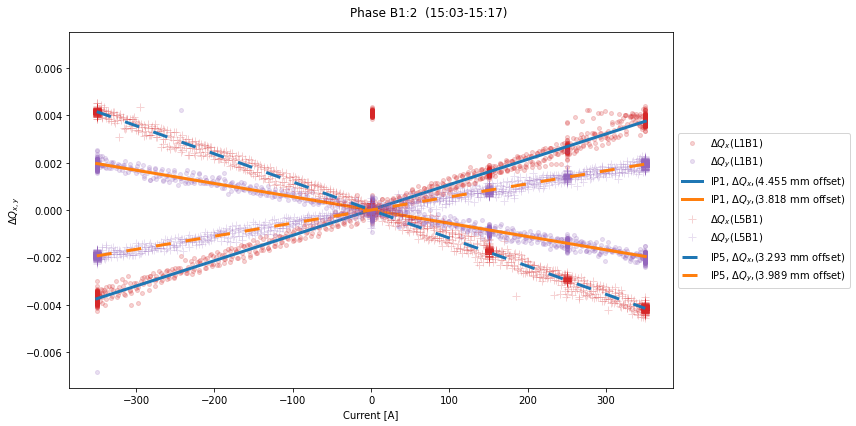

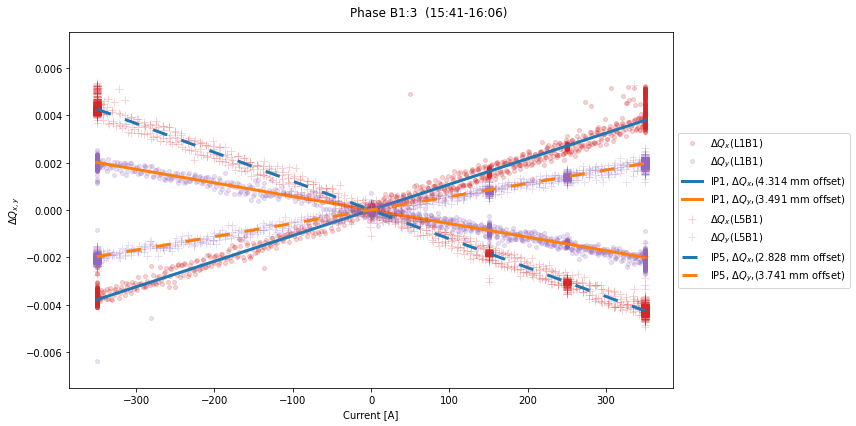

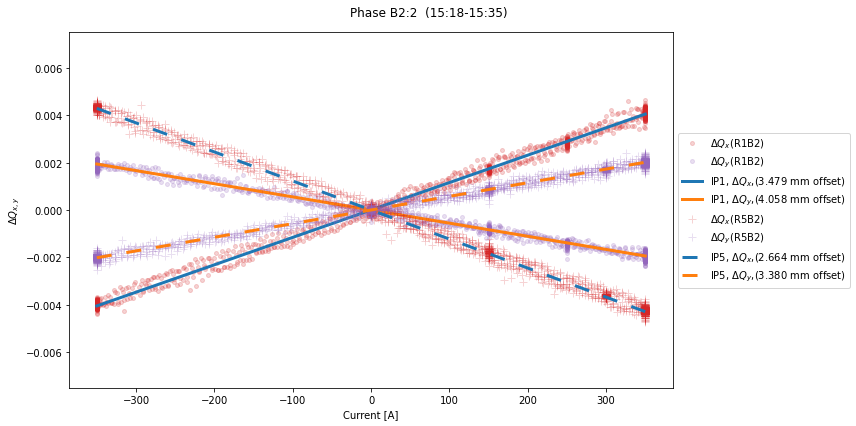

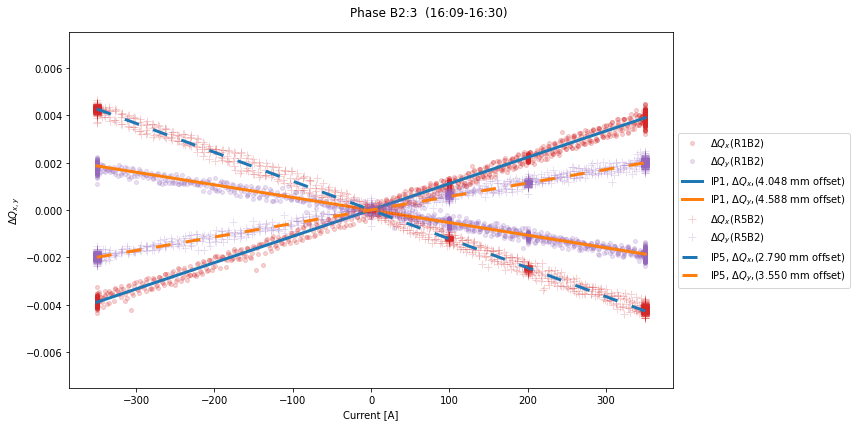

In [27]:


grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    I_vec = np.linspace(-350,350,100)
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            
            mark = '+'
         
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(I_data, DQx_data,mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(I_data, DQy_data,mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Finding collimator position
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2 + 3e-3
        
        # Fitting!
        #==================
        if IP == 'IP1':
            rw,phiw = cart2pol(0,d_coll)
        else:
            rw,phiw = cart2pol(d_coll,0)
        
        # 
        maxValue = 2*np.cos(2*phiw)/rw**2
        p0     = [0.9*maxValue]
        if maxValue>0:
            bounds = (0.1*maxValue,0.999*maxValue)
        else:
            bounds = (0.999*maxValue,0.1*maxValue)
        
        popt_Qx, pcov_Qx = curve_fit(lambda I,A: dQxfit(I,A,betx=wire.betx,E = 450e9,L=1.2),I_data,DQx_data,p0 = p0,bounds=bounds)
        popt_Qy, pcov_Qy = curve_fit(lambda I,A: dQyfit(I,A,bety=wire.bety,E = 450e9,L=1.2),I_data,DQy_data,p0 = p0,bounds=bounds)
        #==================
        
        if IP == 'IP1':

            offset_Qx = extractOffset(popt_Qx[0],xw=None,yw=d_coll)
            offset_Qy = extractOffset(popt_Qy[0],xw=None,yw=d_coll)
            
            ls='-'
        else:
            
            offset_Qx = extractOffset(popt_Qx[0],xw=d_coll,yw=None)
            offset_Qy = extractOffset(popt_Qy[0],xw=d_coll,yw=None)
            
            ls=(0,(5,5))
            
        plt.plot(I_vec,dQxfit(I_vec,*popt_Qx,betx=wire.betx,E = 450e9,L=1.2),linestyle =ls,lw=3,color='C0',label=IP + r', $\Delta Q_x$,'+ f'({offset_Qx/1e-3:.3f} mm offset)')
        plt.plot(I_vec,dQyfit(I_vec,*popt_Qy,bety=wire.bety,E = 450e9,L=1.2),linestyle =ls,lw=3,color='C1',label=IP + r', $\Delta Q_y$,'+ f'({offset_Qy/1e-3:.3f} mm offset)')
        
        #print(f'Err-x : +/-{np.sqrt(np.diag(pcov_Qx))[0]/1e-3:.3f} mm, {np.sqrt(np.diag(pcov_Qx))[0]/popt_Qx[0]*100:.3f}%\nErr-y : +/-{np.sqrt(np.diag(pcov_Qy))[0]/1e-3:.3f} mm, {np.sqrt(np.diag(pcov_Qy))[0]/popt_Qy[0]*100:.3f}%')
        #print(40*'-')
        
        # Saving offset results
        if f'Offset_{IP}_dQx' not in database.columns:
            database.insert(2,f'Offset_{IP}_dQx',np.nan)
            database.insert(3,f'Offset_{IP}_dQy',np.nan)
        
        #print(offset_Qx)
        #print(offset_Qy)
        #print(20*'-')
        database.loc[tuneIndex,f'Offset_{IP}_dQx'] = offset_Qx
        database.loc[tuneIndex,f'Offset_{IP}_dQy'] = offset_Qy
        
        
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.ylim([-0.0075,0.0075])
    
    plt.ylabel(r'$\Delta Q_{x,y}$')
    plt.xlabel(f"{wire.label['I']} [{wire.units['I']}]")
    plt.tight_layout()
    
    

# Trying to emphasize the difference between Phase 2 and 3

Let's assume that we know nothing about $\beta_{x,y},B\rho, L$. One can still study:
$$\frac{\left[\Delta Q_x/I\right]_{\text{Phase 2}}}{\left[\Delta Q_x/I\right]_{\text{Phase 3}}} = \frac{\left[\frac{2(x_w^2-y_w^2)}{(x_w^2+y_w^2)^2}\right]_{\text{Phase 2}}}{\left[\frac{2(x_w^2-y_w^2)}{(x_w^2+y_w^2)^2}\right]_{\text{Phase 3}}}$$


Or, even more simple: $\Delta Q_x/I$ should be constant in both cases with the only difference coming from the shift in the 5th axis.

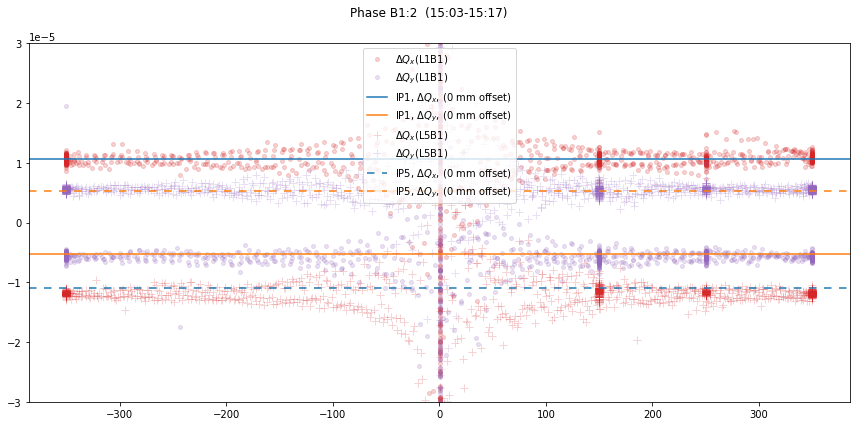

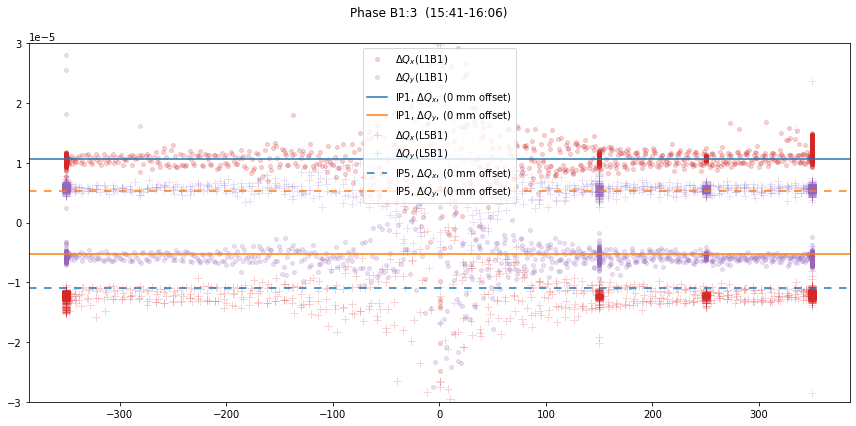

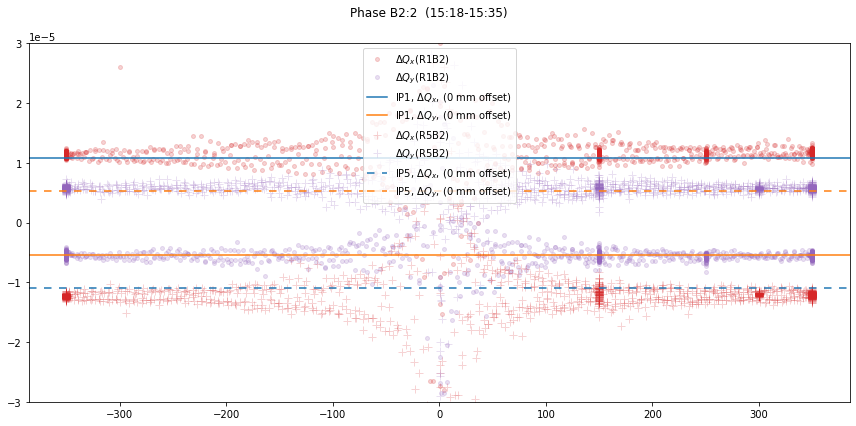

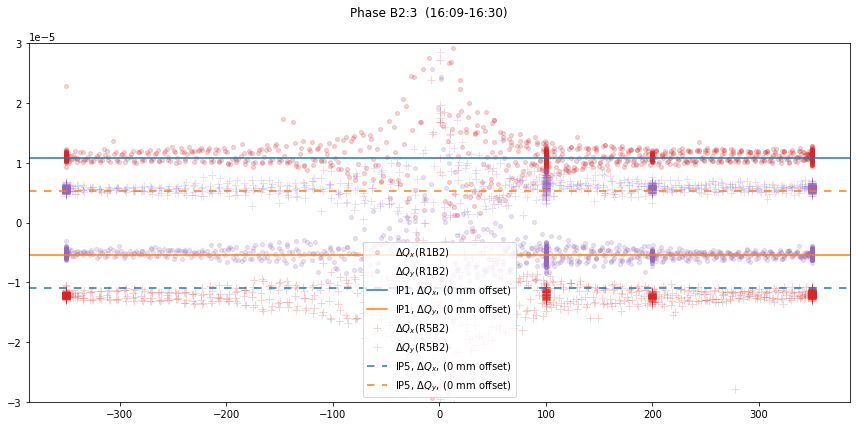

In [28]:

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    I_vec = np.linspace(-350,350,100)
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
         
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2 + 3e-3
        
        
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(np.array(I_data),np.array(DQx_data/I_data),mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(np.array(I_data),np.array(DQy_data/I_data),mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Analytic expression
        if IP == 'IP1':
            dQx_I_min,dQy_I_min = dQxdQy(1,xw = -1e-3     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I_max,dQy_I_max = dQxdQy(1,xw = +1e-3     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I,dQy_I = dQxdQy(1,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx_I_min,dQy_I_min = dQxdQy(1,xw = d_coll,yw = -1e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I_max,dQy_I_max = dQxdQy(1,xw = d_coll,yw = +1e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I,dQy_I = dQxdQy(1,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        
        plt.axhline(dQx_I,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        plt.axhline(dQy_I,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
        
    
    #plt.xlim([-112,2800])
    plt.ylim([-3e-5,3e-5])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Results/dQdI_{beam.name}_Phase{name[-1]}.pdf',format='pdf')
    

In [ ]:
d_coll/1e-3 - 3

In [ ]:
%matplotlib widget

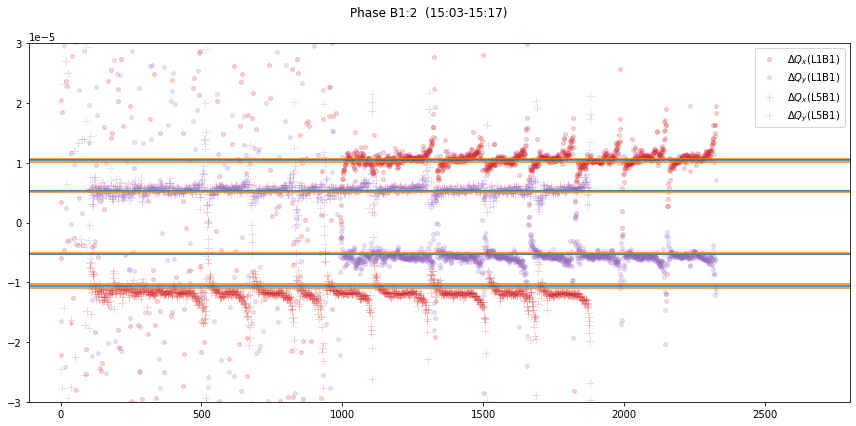

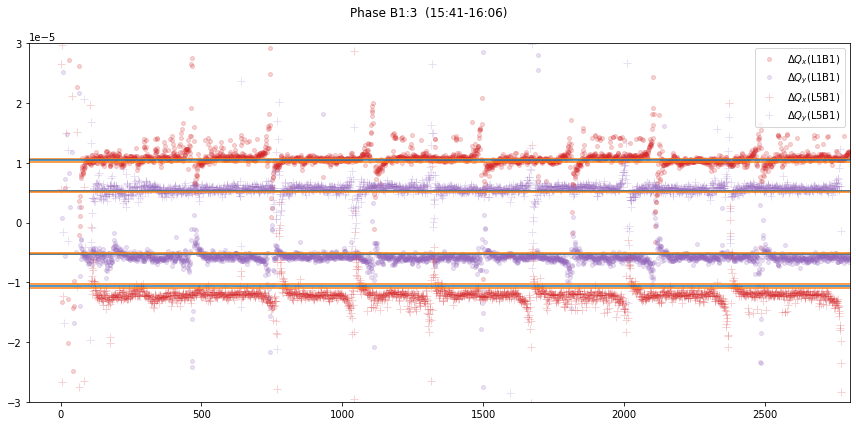

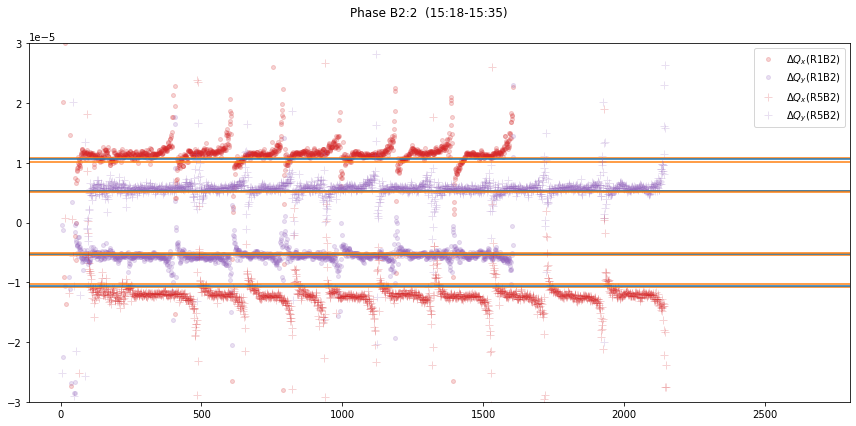

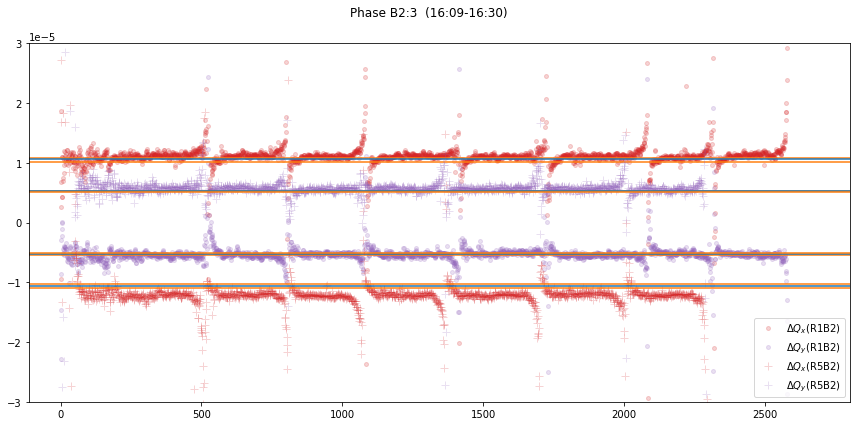

In [29]:

grouped = database.groupby('Phase')
for name, group in grouped:
    if name == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in name:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in name][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    I_vec = np.linspace(-350,350,100)
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
         
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2 + 3e-3
        
        
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(np.array(DQx_data/I_data),mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(np.array(DQy_data/I_data),mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Analytic expression
        if IP == 'IP1':
            dQx_I_min,dQy_I_min = dQxdQy(1,xw = 1.5e-3-1e-3     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I_max,dQy_I_max = dQxdQy(1,xw = 1.5e-3+1e-3     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I,dQy_I = dQxdQy(1,xw = 1.5e-3     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx_I_min,dQy_I_min = dQxdQy(1,xw = d_coll,yw = 1.5e-3-1e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I_max,dQy_I_max = dQxdQy(1,xw = d_coll,yw = 1.5e-3+1e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            dQx_I,dQy_I = dQxdQy(1,xw = d_coll,yw = 1.5e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        
        plt.axhline(dQx_I_min,color='C1')
        plt.axhline(dQx_I    ,color='C0')
        plt.axhline(dQx_I_max,color='C1')
        
        plt.axhline(dQy_I_min,color='C1')
        plt.axhline(dQy_I    ,color='C0')
        plt.axhline(dQy_I_max,color='C1')
        
    
    plt.xlim([-112,2800])
    plt.ylim([-3e-5,3e-5])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Results/dQdI_{beam.name}_Phase{name[-1]}.pdf',format='pdf')
    

# Try to see the effect of a +/- 1 mm between phase 1 and 2

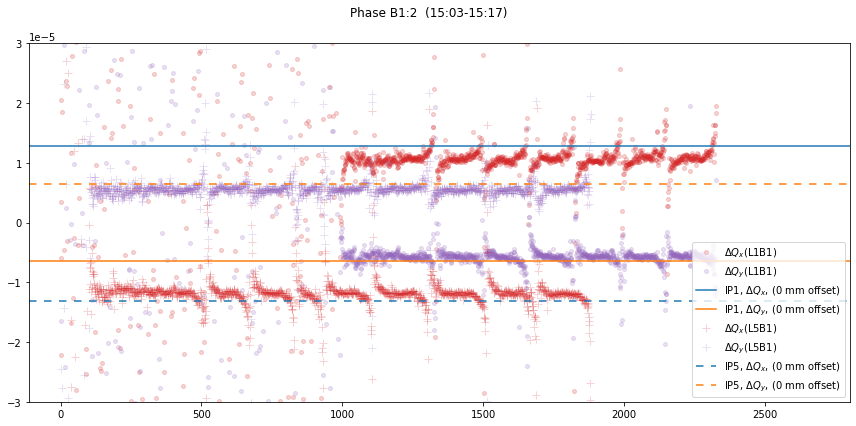

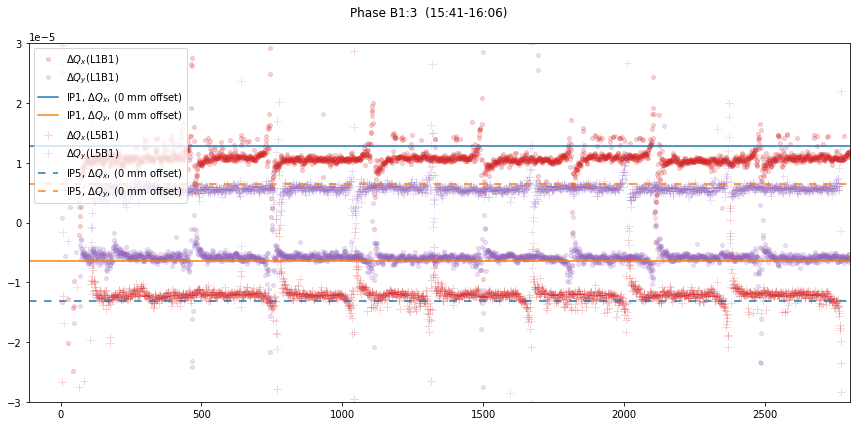

In [30]:


beam = beams[0]

grouped = database.groupby('Phase')
for name in [f'{beam.name}:2',f'{beam.name}:3']:

    group = grouped.get_group(name)
    
    # Selecting proper beam and wires for the group
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = group.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, group.dropna(subset=[wire1['I']])['Time'],
                                   group.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, group.dropna(subset=[wire2['I']])['Time'],
                                   group.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    plt.figure(figsize=(12, 6))
    plt.suptitle('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    
    I_vec = np.linspace(-350,350,100)
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
         
        left_coll  = group[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = group[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*np.mean(left_coll-right_coll)/2 + 3e-3
        
        
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(np.array(DQx_data/I_data),mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(np.array(DQy_data/I_data),mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')

      
        if IP == 'IP1':
            dQx_I,dQy_I = dQxdQy(1,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1.2)
            ls='-'
        else:
            dQx_I,dQy_I = dQxdQy(1,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1.2)
            ls=(0,(5,5))
        
        plt.axhline(dQx_I,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        plt.axhline(dQy_I,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
    
    plt.xlim([-112,2800])
    plt.ylim([-3e-5,3e-5])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Results/dQdI_{beam.name}_Phase{name[-1]}.pdf',format='pdf')
    

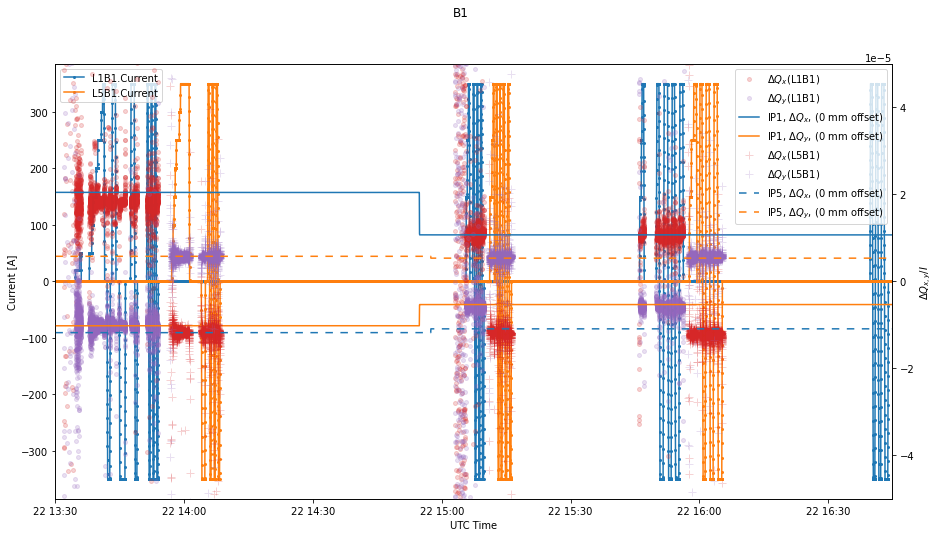

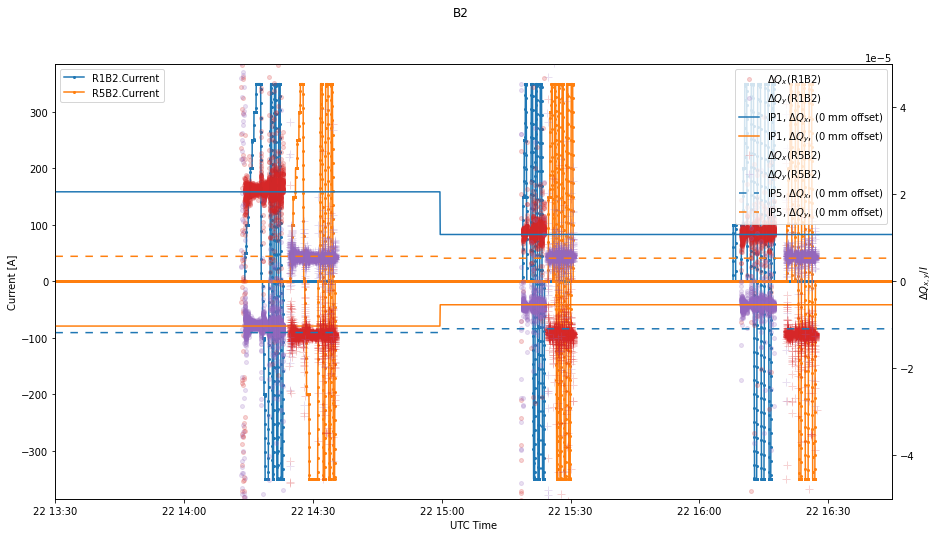

In [31]:


for beam in beams:
    
    
    # Selecting proper beam wires
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = database.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, database.dropna(subset=[wire1['I']])['Time'],
                                   database.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, database.dropna(subset=[wire2['I']])['Time'],
                                   database.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(beam.name)
    for wire,color in zip(wires[beam.name],['C0','C1']):
        database.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        
    ax2 = plt.gca().twinx()
    plt.sca(ax2)
    
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
            
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        plt.plot(DQx_data/I_data,mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(DQy_data/I_data,mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Analytic value
        left_coll  = database[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = database[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*(left_coll-right_coll)/2 + 3e-3
        if IP == 'IP1':
            dQx_I,dQy_I = dQxdQy(1,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx_I,dQy_I = dQxdQy(1,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        
        plt.plot(dQx_I,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        plt.plot(dQy_I,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
    
    plt.ylim([-5e-5,5e-5])
    plt.legend(loc='upper right')
    plt.ylabel(r'$\Delta Q_{x,y}/I$')
    plt.xlim(MDWindow)
    
    


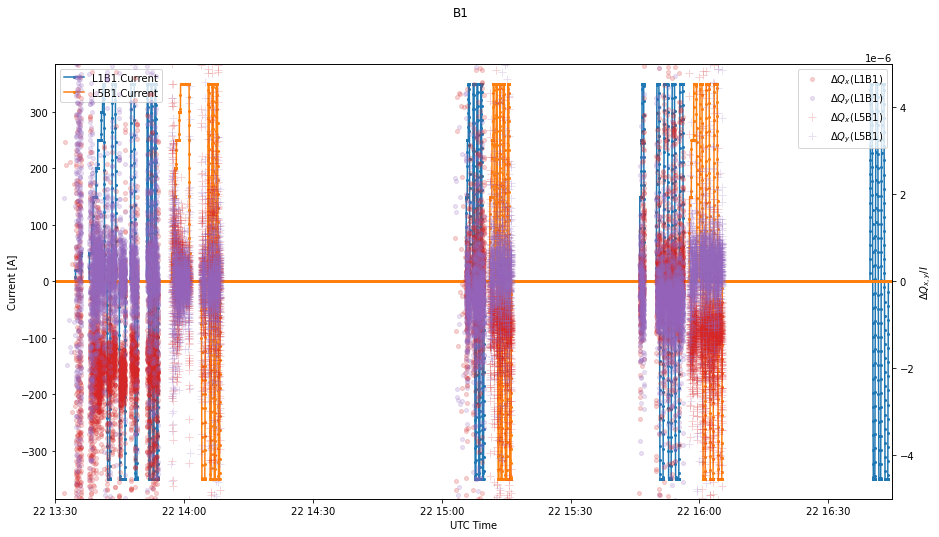

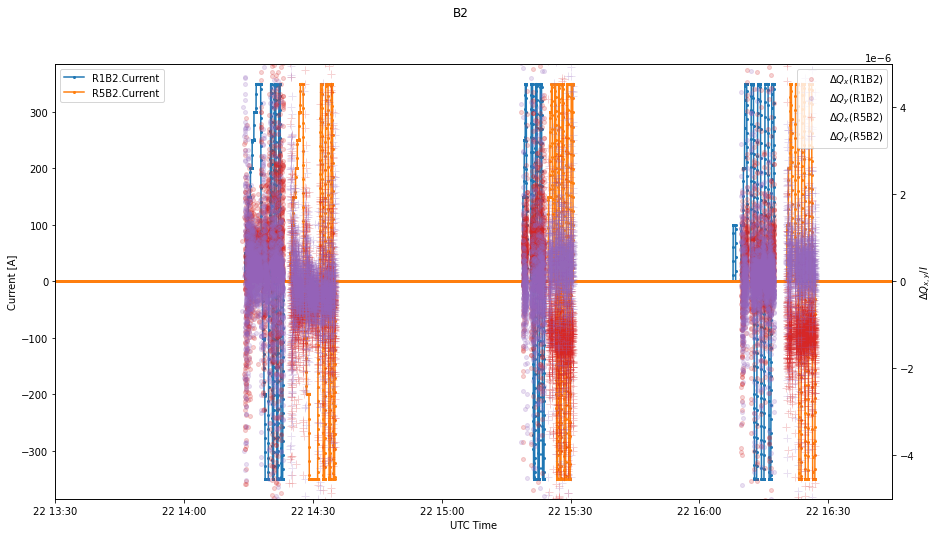

In [32]:


for beam in beams:
    
    
    # Selecting proper beam wires
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    
    # Extracting tune info
    subset = database.dropna(subset=[beam['Qx_HS']+'_shift'])
    tuneIndex = list(subset.index)
    tuneTimes = subset['Time']
    
    DQx = subset[beam['Qx_HS']+'_shift']
    DQy = subset[beam['Qy_HS']+'_shift']
    

    # Interpolating both currents
    I_wire1 = np.interp(tuneTimes, database.dropna(subset=[wire1['I']])['Time'],
                                   database.dropna(subset=[wire1['I']])[wire1['I']])

    I_wire2 = np.interp(tuneTimes, database.dropna(subset=[wire2['I']])['Time'],
                                   database.dropna(subset=[wire2['I']])[wire2['I']])
    
    # Choosing which current to look at
    on_wire1 = (np.abs(I_wire1)>0.1) & (np.abs(I_wire1)>np.abs(I_wire2))
    on_wire2 = (np.abs(I_wire2)>0.1) & (np.abs(I_wire2)>np.abs(I_wire1))
    
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(beam.name)
    for wire,color in zip(wires[beam.name],['C0','C1']):
        database.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        
    ax2 = plt.gca().twinx()
    plt.sca(ax2)
    
    for wire,I_wire,on_wire in zip([wire1,wire2],[I_wire1,I_wire2],[on_wire1,on_wire2]):
        IP = 'IP' + wire.loc[1]
        if IP == 'IP1':
            mark = '.'
        else:
            mark = '+'
            
        # For each wire, plotting DQx, DQy
        I_data, DQx_data, DQy_data = I_wire[on_wire],DQx[on_wire],DQy[on_wire]
        #plt.plot(DQx_data/I_data,mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        #plt.plot(DQy_data/I_data,mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        
        # Analytic value
        left_coll  = database[[wire.Position['Left Upstream'] ,wire.Position['Left Downstream']]].dropna().mean(axis=1)
        right_coll = database[[wire.Position['Right Upstream'],wire.Position['Right Downstream']]].dropna().mean(axis=1)
        # Convert mm to m, then additionnal 3mm for wire-in-jaw
        d_coll     = 1e-3*(left_coll-right_coll)/2 + 3e-3
        if IP == 'IP1':
            dQx_I,dQy_I = dQxdQy(1,xw = 0     ,yw = d_coll, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls='-'
        else:
            dQx_I,dQy_I = dQxdQy(1,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
            ls=(0,(5,5))
        
        diff_Qx = DQx_data/I_data - np.interp(tuneTimes[on_wire],(dQx_I.index - database.index[0]).total_seconds(),dQx_I.values)
        diff_Qy = DQy_data/I_data - np.interp(tuneTimes[on_wire],(dQy_I.index - database.index[0]).total_seconds(),dQy_I.values)
        
        
        plt.plot(diff_Qx,mark,ms=8,alpha=0.2,color='C3',label=r'$\Delta Q_x$' + f'({wire.loc})')
        plt.plot(diff_Qy,mark,ms=8,alpha=0.2,color='C4',label=r'$\Delta Q_y$' + f'({wire.loc})')
        
        #plt.plot(dQx_I,linestyle =ls,color='C0',label=IP + r', $\Delta Q_x$, (0 mm offset)')
        #plt.plot(dQy_I,linestyle =ls,color='C1',label=IP + r', $\Delta Q_y$, (0 mm offset)')
    
    plt.ylim([-5e-6,5e-6])
    plt.legend(loc='upper right')
    plt.ylabel(r'$\Delta Q_{x,y}/I$')
    plt.xlim(MDWindow)
    
    


In [ ]:
DQx_data

In [ ]:
np.interp(tuneTimes,(dQx_I.index - database.index[0]).total_seconds(),dQx_I.values)

In [ ]:
d_coll

In [ ]:
Qx_1,Qy_1  =dQxdQy(1,xw = d_coll,yw = 0, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)
Qx_2,Qy_2  =dQxdQy(1,xw = d_coll,yw =1e-3, betx=wire.betx,bety=wire.bety, E = 450e9,L=1)

#print(f'Exp. Relative change with Qx: {(Qx_2-Qx_1)/Qx_1*100:.2f}%')
#print(f'Exp. Relative change with Qy: {(Qy_2-Qy_1)/Qy_1*100:.2f}%')

In [ ]:
(Qx_2-Qx_1)

In [ ]:
(Qy_2-Qy_1)

In [ ]:
(Qy_2/Qy_1) - (Qx_2/Qx_1)

In [ ]:

def extractOffset(A,xw=None,yw=None):
    
    if yw is not None:
        pref = np.sqrt(1-4*A*yw**2)/A
        return np.sqrt(-pref + 1/A - yw**2)#(np.sqrt(-pref + 1/A - yw**2),np.sqrt(pref + 1/A - yw**2))
    
    if xw is not None:
        pref = np.sqrt(4*A*xw**2+1)/A
        return (np.sqrt(-pref - 1/A - xw**2),np.sqrt(pref - 1/A - xw**2))
    
#==========================================

In [ ]:
yw = d_coll
A = popt_Qx[0]
pref = np.sqrt(1-4*A*yw**2)/A
+pref + 1/A - yw**2

In [ ]:
np.sqrt(pref + 1/A - yw**2)

In [ ]:


extractOffset(popt_Qy[0],yw=d_coll)

In [ ]:
grouped = database.groupby('Phase')

# Looking for diffenrence between phase 2 and 3


for beam in ['B1','B2']:  
    print('\n\n')
    name = f'{beam}:2'
    print('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    name = f'{beam}:3'
    print('Phase ' + name + f"  ({phase_list[name][0].strftime('%H:%M')}-{phase_list[name][1].strftime('%H:%M')})")
    print(40*'=')

    for IP in ['IP1','IP5']:
        change_x = grouped.get_group(f'{beam}:2')[f'Offset_{IP}_dQx'].dropna()[-1] - grouped.get_group(f'{beam}:3')[f'Offset_{IP}_dQx'].dropna()[-1]
        change_y = grouped.get_group(f'{beam}:2')[f'Offset_{IP}_dQy'].dropna()[-1] - grouped.get_group(f'{beam}:3')[f'Offset_{IP}_dQy'].dropna()[-1]
        
        print(f'({beam},{IP}),Phase2-Phase3 offset change\n \t from Qx :{change_x/1e-6:.2f} um\n \t from Qy :{change_y/1e-6:.2f} um\n' + 40*'-')
    print(40*'=')

# BPM

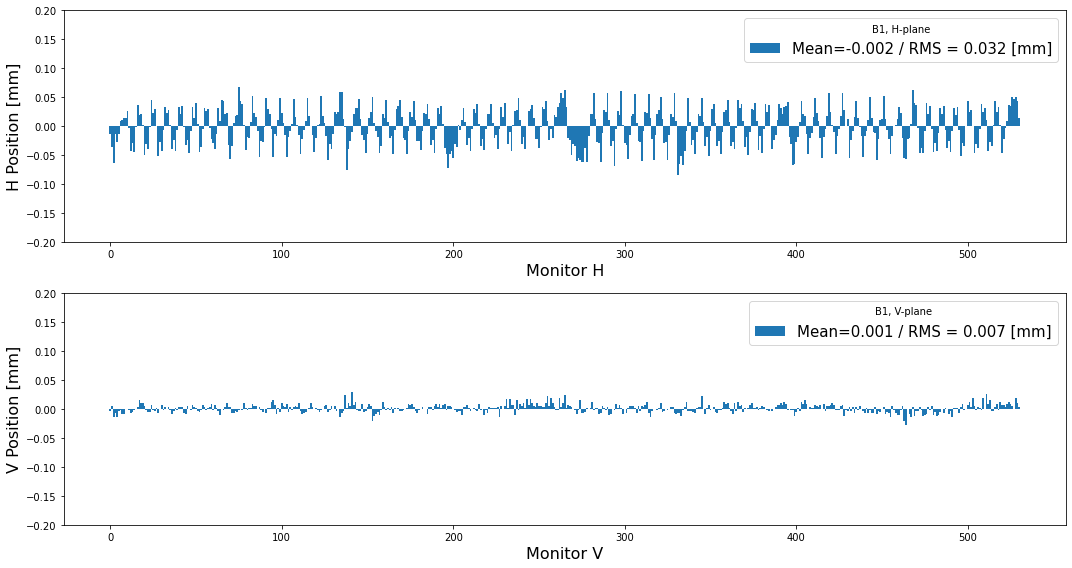

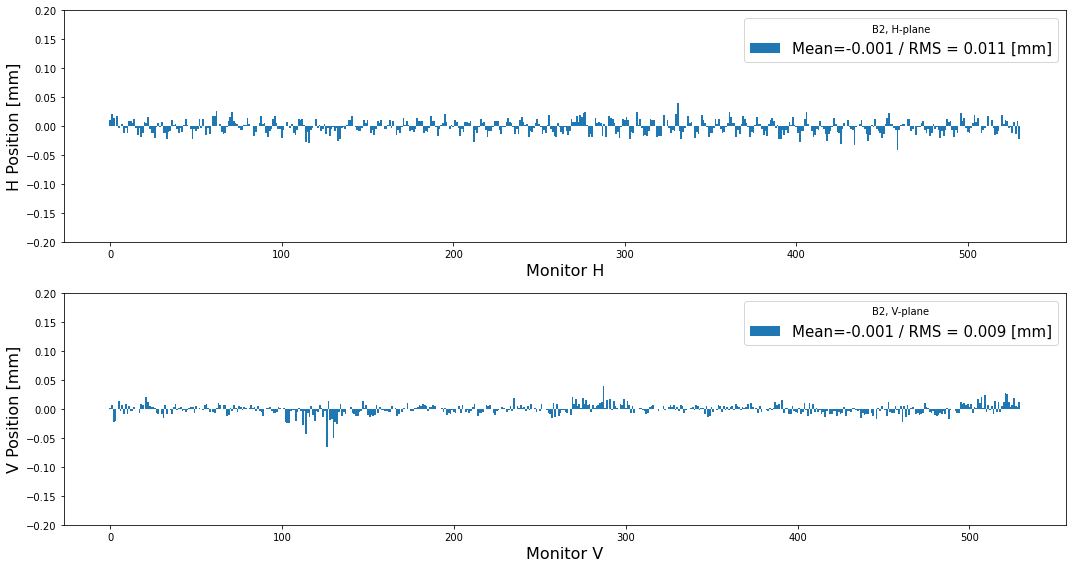

In [33]:

# Extracting BPM INFO
#BPM_data = pd.concat([nx.getBPMValues(database,beam) for beam in beams],axis=1)
refTime = '2022-05-22 14:24:00'
obsTime = '2022-05-22 14:29:12'



for beam in beams:
    
    ref_BPM       = nx.getBPM_fromTs(refTime,database,beam)
    extracted_BPM = nx.getBPM_fromTs(obsTime,database,beam)
    
    fig, axes = plt.subplots(2,figsize=(15,8))
    for plane,ax in zip(['H','V'],axes):
        
        
        plt.sca(ax)
    
        #s = np.array([twiss[beam.name].loc[name.lower(),'s'] for name in  snapshot[f'Mask_{beam.name}_{plane}']])
        #bet = np.array([twiss[beam.name].loc[name.lower(),{'H':'betx','V':'bety'}[plane]] for name in  snapshot[f'Mask_{beam.name}_{plane}']])
        #plt.plot( s,snapshot[f'BPMValues_{beam.name}_{plane}']/np.sqrt(bet))
        
        CO = extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']-ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']
        plt.bar(range(len(CO)),CO/1e-3,width=1,label=f'Mean={np.mean(CO/1e-3):.3f} / RMS = {np.std(CO/1e-3):.3f} [mm]')
        
        plt.legend(title=f'{beam.name}, {plane}-plane',fontsize=15)
        
        plt.ylim([-0.2,0.2])
        plt.ylabel(f'{plane} Position [mm]',fontsize=16)
        plt.xlabel(f'Monitor {plane}',fontsize=16)
        
        plt.tight_layout()


## BPM Normalisation test

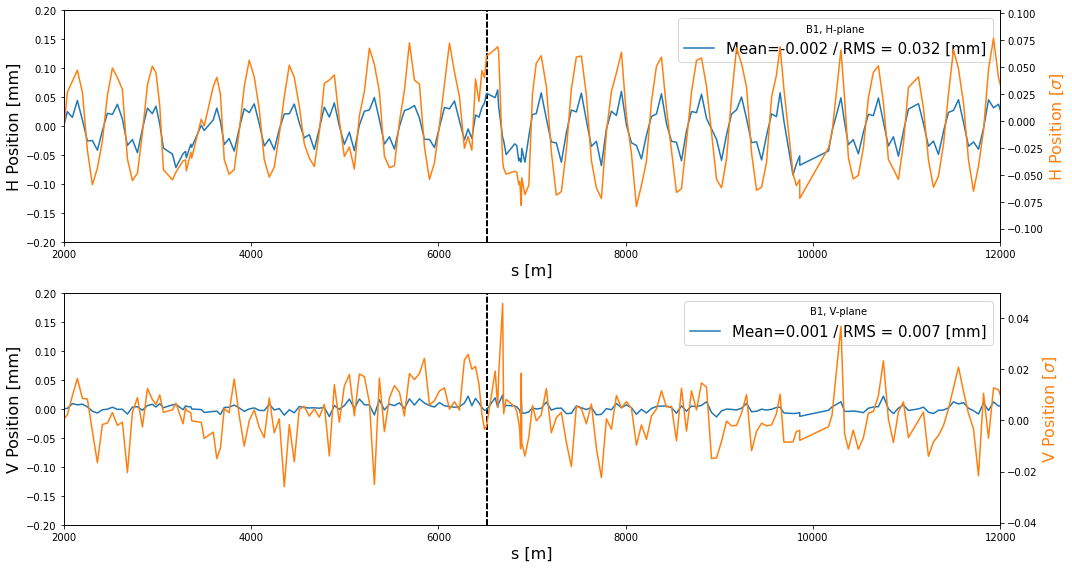

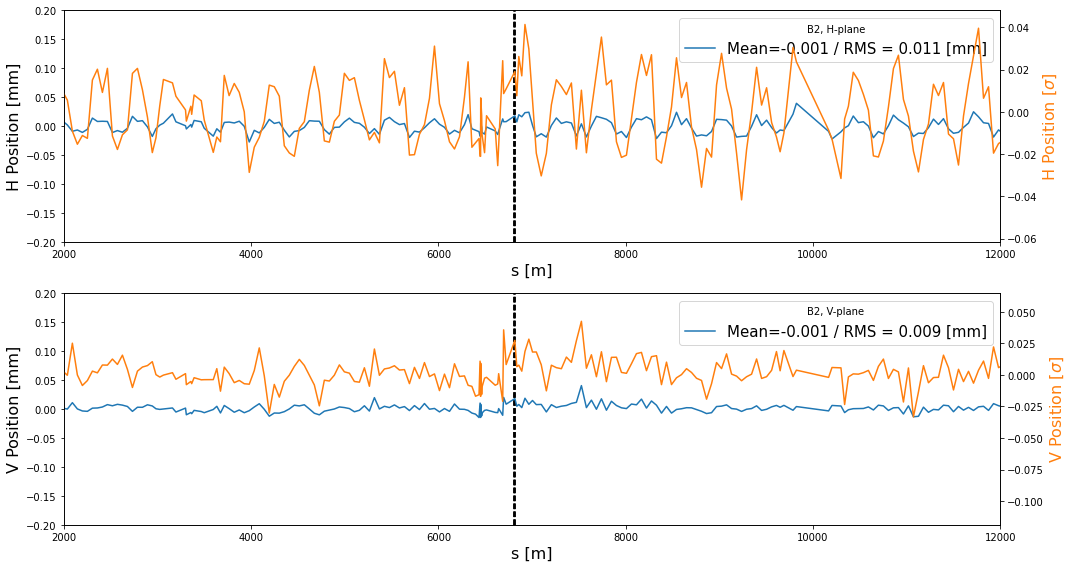

In [34]:


refTime = '2022-05-22 14:24:00'
obsTime = '2022-05-22 14:29:12'

emitt  = 2.5e-6/(1+450e9/cst.m_p_eV)

for beam in beams:
    
    ref_BPM       = nx.getBPM_fromTs(refTime,database,beam)
    extracted_BPM = nx.getBPM_fromTs(obsTime,database,beam)
    
    fig, axes = plt.subplots(2,figsize=(15,8))
    for plane,ax in zip(['H','V'],axes):
        
        
        plt.sca(ax)
    
        s,bet = (twiss[beam.name].loc[ref_BPM[f'Mask_{beam.name}_{plane}'],c] for c in ['s',{'H':'betx','V':'bety'}[plane]])
        _tw_wires = [name for name in twiss[beam.name].index if 'bbcw' in name]
    
        CO = extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']-ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']
        order = np.argsort(s)
        
        for _tw_wire in _tw_wires:
            plt.axvline(twiss[beam.name].loc[_tw_wire,'s'],linestyle='--',color='k')
        
        plt.plot(s[order],CO[order]/1e-3,label=f'Mean={np.mean(CO/1e-3):.3f} / RMS = {np.std(CO/1e-3):.3f} [mm]')
        plt.legend(title=f'{beam.name}, {plane}-plane',fontsize=15)
        plt.ylim([-0.2,0.2])
        plt.ylabel(f'{plane} Position [mm]',fontsize=16)
        plt.xlabel(f's [m]',fontsize=16)
        
        ax2 = ax.twinx()
        plt.plot(s[order],CO[order]/np.sqrt(emitt*bet[order]),color='C1')
        plt.ylabel(fr'{plane} Position [$\sigma$]',fontsize=16)
        ax2.yaxis.label.set_color('C1')
        
        plt.xlim([7e3-5e3,7e3+5e3])
        plt.tight_layout()


# With Average?

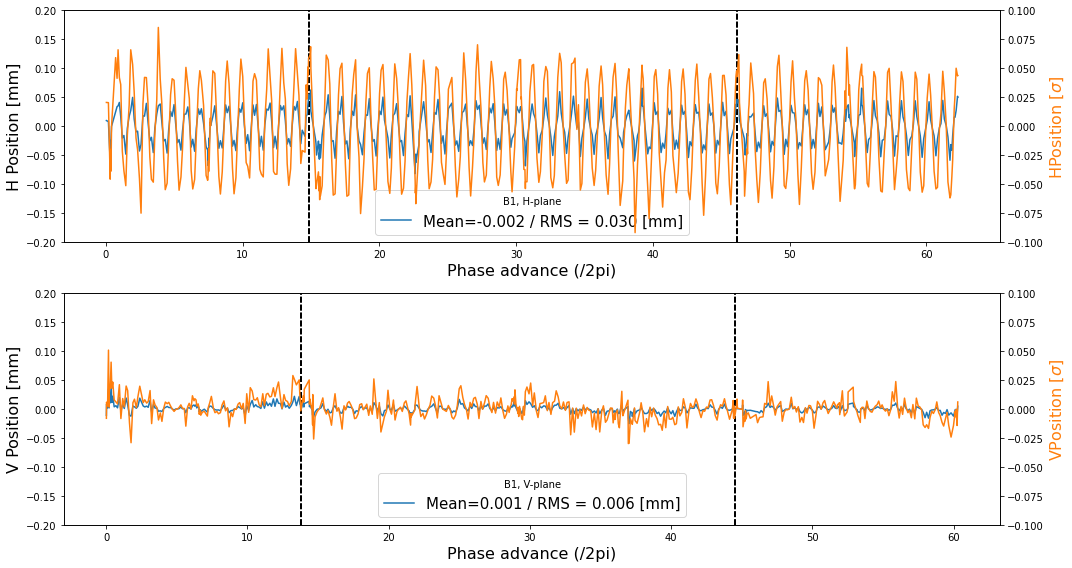

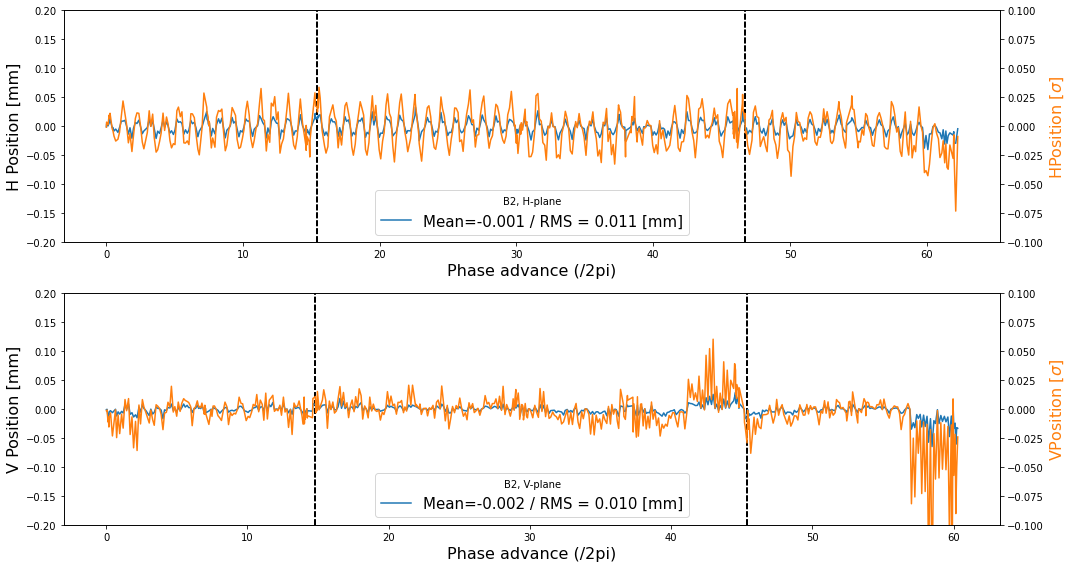

In [45]:


refTime = '2022-05-22 14:24:00'
obsTime = '2022-05-22 14:29:12'

emitt  = 2.5e-6/(1+450e9/cst.m_p_eV)





for beam in beams:
    
    aveTime = 45
    ref_BPM       = nx.getBPM_average(refTime,pd.Timestamp(refTime) + pd.Timedelta(seconds=aveTime),database,beam)
    #extracted_BPM = nx.getBPM_average(obsTime,pd.Timestamp(obsTime) + pd.Timedelta(seconds=aveTime),database,beam)
    extracted_BPM = nx.getBPM_fromTs(obsTime,database,beam)
    
    fig, axes = plt.subplots(2,figsize=(15,8))
    for plane,ax in zip(['H','V'],axes):
        
        
        # Extracting BPM values
        _extract = pd.DataFrame({'Value-BPM':extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=extracted_BPM[f'Mask_{beam.name}_{plane}'])
        _ref     = pd.DataFrame({'Value-Ref':ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=ref_BPM[f'Mask_{beam.name}_{plane}'])

        # Extracting twiss parameter from BPM name
        
        mu_i,bet_i = {'H':'mux','V':'muy'}[plane], {'H':'betx','V':'bety'}[plane]
        mu,bet = (twiss[beam.name].loc[ref_BPM[f'Mask_{beam.name}_{plane}'],c] for c in [mu_i,bet_i])
        
        # Putting all the info together to align index (BLM name)
        BPM_df = pd.concat([mu,bet,_ref,_extract],axis=1)
        BPM_df.insert(4,'CO',BPM_df['Value-BPM']-BPM_df['Value-Ref'])
        BPM_df.sort_values(by=mu_i,inplace=True)


        plt.sca(ax)
    
        
        _tw_wires = [name for name in twiss[beam.name].index if 'bbcw' in name]
        for _tw_wire in _tw_wires:
            plt.axvline(twiss[beam.name].loc[_tw_wire,mu_i],linestyle='--',color='k')
        
        
        plt.plot(BPM_df[mu_i],BPM_df['CO']/1e-3,label=f'Mean={np.mean(BPM_df["CO"]/1e-3):.3f} / RMS = {np.std(BPM_df["CO"]/1e-3):.3f} [mm]')
        plt.legend(title=f'{beam.name}, {plane}-plane',fontsize=15)
        plt.ylim([-0.2,0.2])
        plt.ylabel(f'{plane} Position [mm]',fontsize=16)
        plt.xlabel(f'Phase advance (/2pi)',fontsize=16)
        
        ax2 = ax.twinx()
        plt.plot(BPM_df[mu_i],BPM_df['CO']/np.sqrt(emitt*BPM_df[bet_i]),color='C1')
        plt.ylabel(f'{plane}'+ r'Position [$\sigma$]',fontsize=16)
        ax2.yaxis.label.set_color('C1')
        plt.ylim([-0.1,0.1])
        
        #plt.xlim([7e3-5e3,7e3+5e3])
        #plt.xlim([5,25])
        plt.tight_layout()


# Let's scan the data

In [2]:
def Make_IP_Fig():
    fig, _axes = plt.subplots(ncols=2, nrows=3)
    gs = _axes[1, 1].get_gridspec()
    # remove the underlying axes
    for ax in _axes[-1, :]:
        ax.remove()
    axbig = fig.add_subplot(gs[-1, :])

    axes = {('B1','IP1'):_axes[0,0],('B1','IP5'):_axes[0,1],
            ('B2','IP1'):_axes[1,0],('B2','IP5'):_axes[1,1],
            'Current'   : axbig}

    return fig,axes


def Make_LHC_Fig(figsize = (10,8)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=3)

    axes = {'B1':_axes[0],
            'B2':_axes[1],
            'Current' : _axes[2]}

    return fig,axes

In [3]:
plt.close('all')
%matplotlib agg
%matplotlib agg

emitt  = 2.5e-6/(1+450e9/cst.m_p_eV)

grouped = database.groupby('Phase')
for phase, group in grouped:
    if phase == 'None':
        continue
    
    # SKIPPING PHASE 1
    if ':1' in phase:
        continue
            
    # Selecting proper beam and wires for the group
    beam = [beam for beam in beams if beam.name in phase][0]
    wire1 = wires[beam.name][0]
    wire2 = wires[beam.name][1]
    
    # Finding max index for ref
    I1_start = np.min(np.where(np.abs(group[wire1['I']].dropna())>1))
    I2_start = np.min(np.where(np.abs(group[wire2['I']].dropna())>1))
    
    ref_stop = np.min([group[wire1['I']].dropna().index[I1_start],
                       group[wire2['I']].dropna().index[I2_start]]) #- pd.Timedelta(minutes=1)
    
    ref_start = group.index[0]
    
    
    
    
    nCuts = 99
    
    for num,ts in enumerate(group.index[::len(group.index)//(nCuts-1)]):
            
        
        #fig,axes = MakeCustomGrid()
        fig,axes = Make_LHC_Fig()
        
        for beam in beams:
            plt.sca(axes[beam.name])
            
            
            ref_BPM  = nx.getBPM_average(ref_start,ref_stop,database,beam)
            extracted_BPM = nx.getBPM_fromTs(ts,database,beam)
        
            for plane in ['H','V']:
                # Extracting BPM values
                _extract = pd.DataFrame({'Value-BPM':extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=extracted_BPM[f'Mask_{beam.name}_{plane}'])
                _ref     = pd.DataFrame({'Value-Ref':ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=ref_BPM[f'Mask_{beam.name}_{plane}'])

                # Extracting twiss parameter from BPM name

                mu_i,bet_i = {'H':'mux','V':'muy'}[plane], {'H':'betx','V':'bety'}[plane]
                mu,bet = (twiss[beam.name].loc[ref_BPM[f'Mask_{beam.name}_{plane}'],c] for c in [mu_i,bet_i])

                #mu = mu - 
                
                # Putting all the info together to align index (BLM name)
                BPM_df = pd.concat([mu,bet,_ref,_extract],axis=1)
                BPM_df.insert(4,'CO',BPM_df['Value-BPM']-BPM_df['Value-Ref'])
                BPM_df.sort_values(by=mu_i,inplace=True)
        
                # PLOTTING
                meta = f'Mean={np.mean(BPM_df["CO"]/np.sqrt(emitt*BPM_df[bet_i])):.3f} / RMS = {np.std(BPM_df["CO"]/np.sqrt(emitt*BPM_df[bet_i])):.3f}'+r' [$\sigma$]'
                plt.plot(BPM_df[mu_i],BPM_df['CO']/np.sqrt(emitt*BPM_df[bet_i]),label=f'{plane}-position ||'+meta)
                
                _tw_wires = [name for name in twiss[beam.name].index if 'bbcw' in name]
                for _tw_wire in _tw_wires:    
                    plt.axvline(twiss[beam.name].loc[_tw_wire,{'H':'mux','V':'muy'}[plane]],linestyle='--',color={'H':'C0','V':'C1'}[plane])
            
            plt.legend(loc='lower center',fontsize=8)
            plt.xlabel(r'$\mu_x\quad |\quad \mu_y$',fontsize=14)
            plt.ylabel(r'$x/\sqrt{\epsilon\beta_x}\quad |\quad y/\sqrt{\epsilon\beta_y}$',fontsize=14)
            plt.ylim([-0.1,0.1])
        
        # Plotting current
        plt.sca(axes['Current'])
        for wire,color in zip(wires[phase[:2]],['C0','C1']):
            group.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
        plt.axvline(ts,color='k')
        plt.legend(loc='upper left')
        plt.xlabel('UTC Time')
        plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
        plt.yticks([-350,-150,150,350])
        
        fig.tight_layout()
        fig.savefig(f'Results_CO/LHC_Phase{phase.replace(":","_")}_TS_{str(num).zfill(3)}.png',format='png',dpi=200)
        plt.close()
    

In [52]:
_tw_wires = [name for name in twiss[beam.name].index if 'bbcw' in name]
_tw_wires

['bbcwi_wire.4r5.d.b2',
 'bbcwe_wire.4r5.d.b2',
 'bbcwi_wire.4r5.u.b2',
 'bbcwe_wire.4r5.u.b2',
 'bbcwt_wire.a4r1.d.b2',
 'bbcwb_wire.a4r1.d.b2',
 'bbcwt_wire.a4r1.u.b2',
 'bbcwb_wire.a4r1.u.b2']

In [10]:
mu,bet = (twiss[beam.name].loc[ref_BPM[f'Mask_{beam.name}_{plane}'],c] for c in [{'H':'mux','V':'muy'}[plane],{'H':'betx','V':'bety'}[plane]])
_tw_wires = [name for name in twiss[beam.name].index if 'bbcw' in name]

CO = extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']-ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']
order = np.argsort(mu)

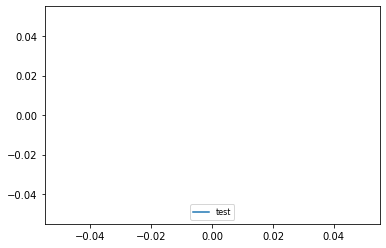

In [5]:
plt.figure()
plt.plot([None],[None],label='test')


In [42]:
_extract = pd.DataFrame({'Value-BPM':extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=extracted_BPM[f'Mask_{beam.name}_{plane}'])
_ref     = pd.DataFrame({'Value-Ref':ref_BPM[f'BPMValues_{beam.name}_{plane} [m]']},index=ref_BPM[f'Mask_{beam.name}_{plane}'])


BPM_df = pd.concat([mu,bet,_ref,_extract],axis=1)

BPM_df.insert(4,'CO',BPM_df['Value-BPM']-BPM_df['Value-Ref'])
display(BPM_df)
BPM_df.sort_values(by={'H':'mux','V':'muy'}[plane],inplace=True)
display(BPM_df)

muy        bety  Value-Ref  Value-BPM            CO
bpmsw.1r1.b2  45.173872   53.273278   0.004474   0.004475  1.201663e-06
bpms.2r1.b2   45.198954   59.555668   0.004670   0.004669 -1.193432e-06
bpmsy.4r1.b2  45.242488  187.874756   0.007036   0.007045  8.637435e-06
bpmwb.4r1.b2  45.377806   81.173344   0.001484   0.001489  4.846536e-06
bpmya.4r1.b2  45.417999   94.199417   0.000923   0.000923 -2.244832e-07
...                 ...         ...        ...        ...           ...
bpmya.4l1.b2  44.637785  191.787569  -0.001851  -0.001852 -5.221570e-07
bpmwb.4l1.b2  44.655616  171.460052  -0.002134  -0.002135 -1.094798e-06
bpmsy.4l1.b2  44.776977  105.527548  -0.005364  -0.005363  9.639330e-07
bpms.2l1.b2   44.804684  159.118027  -0.006743  -0.006742  8.778295e-07
bpmsw.1l1.b2  44.823975   53.332112  -0.003867  -0.003869 -1.755920e-06

[530 rows x 5 columns]

muy        bety  Value-Ref  Value-BPM        CO
bpmw.4r3.b2     0.022282  118.349446   0.000083   0.000092  0.000008
bpmwe.4r3.b2    0.067909   97.076613   0.000280   0.000284  0.000004
bpmw.5r3.b2     0.141337  293.391595  -0.000303  -0.000305 -0.000002
bpmwe.a5r3.b2   0.156782  259.857715   0.000188   0.000192  0.000005
bpmwc.6r3.b2    0.199621   86.278418   0.000503   0.000511  0.000008
...                  ...         ...        ...        ...       ...
bpm.7l3.b2     60.018819   67.011994  -0.000004  -0.000005 -0.000001
bpmr.6l3.b2    60.112775  243.293933  -0.000620  -0.000619  0.000001
bpmwj.a5l3.b2  60.158654   88.131892   0.001349   0.001357  0.000008
bpmw.5l3.b2    60.222469   77.593132   0.000172   0.000171 -0.000001
bpmwe.4l3.b2   60.295851  367.482866  -0.000332  -0.000330  0.000002

[530 rows x 5 columns]

In [23]:




BPM_df = pd.DataFrame({f'CO_{beam.name}_{plane}':extracted_BPM[f'BPMValues_{beam.name}_{plane} [m]']-ref_BPM[f'BPMValues_{beam.name}_{plane} [m]'],
                      })

In [28]:
extracted_BPM[f'Mask_{beam.name}_{plane}'] == ref_BPM[f'Mask_{beam.name}_{plane}']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

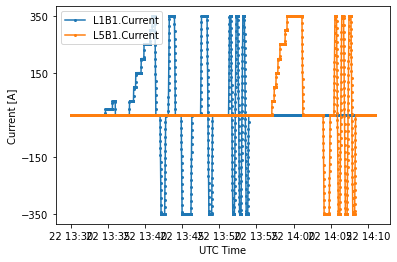

In [18]:
name = 'B1:1'
group = grouped.get_group(name)

# Selecting proper beam and wires for the group
beam = [beam for beam in beams if beam.name in name][0]
wire1 = wires[beam.name][0]
wire2 = wires[beam.name][1]

%matplotlib inline
plt.figure()
for wire,color in zip(wires[name[:2]],['C0','C1']):
    group.nxPlot('index',wire['I'],'-o',ms=2,label = wire.loc + '.' + wire.label['I'])
    #plt.axvline(ts,color='k')
    plt.legend(loc='upper left')
    plt.xlabel('UTC Time')
    plt.ylabel(f"{wire.label['I']} [{wire.units['I']}]")
    plt.yticks([-350,-150,150,350])

In [52]:
group.index[::len(group.index)//(nCuts-1)]

DatetimeIndex(['2022-05-22 13:30:00.000488275+00:00',
                  '2022-05-22 13:34:33.677970+00:00',
                  '2022-05-22 13:39:07.278576+00:00',
                  '2022-05-22 13:43:40.714628+00:00',
                  '2022-05-22 13:48:13.840703+00:00',
                  '2022-05-22 13:52:47.119356+00:00',
                  '2022-05-22 13:57:20.554763+00:00',
                  '2022-05-22 14:01:53.517944+00:00',
                  '2022-05-22 14:06:26.477914+00:00',
                  '2022-05-22 14:10:59.755198+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

2022-05-22 13:50:53.080000+00:00      0.000011
2022-05-22 14:00:20.580000+00:00      0.000012
2022-05-22 13:30:47.580000+00:00      0.000012
2022-05-22 14:06:51.080000+00:00      0.000027
2022-05-22 14:04:42.580000+00:00      0.000040
                                       ...    
2022-05-22 13:48:03.080000+00:00    350.007294
2022-05-22 13:43:55.580000+00:00    350.007538
2022-05-22 13:53:17.580000+00:00    350.007568
2022-05-22 13:43:55.080000+00:00    350.007874
2022-05-22 13:43:56.580000+00:00    350.010254
Name: RPMC.UL14.RBBCW.L1B1:I_MEAS, Length: 3073, dtype: float32

Mask_B1_H  \
2022-05-22 15:03:00.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:01.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:02.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:03.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:04.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
...                                                                             ...   
2022-05-22 15:05:34.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:35.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:36.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:37.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:38.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   

                                                                 BPMValues_B1_H [m]  \
2022-05-22 15:03:00.340000+00:00  [-0.002399161931793883, -0.0017658884619081124...   
2022-05-22 15:03:01.340000+00:00  [-0.0023962253608218634, -0.001754286641951460...   
2022-05-22 15:03:02.340000+00:00  [-0.002406045499835502, -0.0017598855326085966...   
2022-05-22 15:03:03.340000+00:00  [-0.0023949458017718697, -0.001754026163374753...   
2022-05-22 15:03:04.340000+00:00  [-0.0023987295971719174, -0.001757569582568487...   
...                                                                             ...   
2022-05-22 15:05:34.340000+00:00  [-0.0024076112286159027, -0.001762472027004537...   
2022-05-22 15:05:35.340000+00:00  [-0.0024113353771421987, -0.001761854498192074...   
2022-05-22 15:05:36.340000+00:00  [-0.0024191966718808884, -0.001763699381090672...   
2022-05-22 15:05:37.340000+00:00  [-0.002422159721981271, -0.0017592244597190356...   
2022-05-22 15:05:38.340000+00:00  [-0.002415119273256484, -0.0017696273623261129...   

                                                                          Mask_B1_V  \
2022-05-22 15:03:00.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:01.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:02.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:03.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:03:04.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
...                                                                             ...   
2022-05-22 15:05:34.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:35.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:36.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:37.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   
2022-05-22 15:05:38.340000+00:00  [bpmsw.1r1.b1, bpms.2r1.b1, bpmsy.4r1.b1, bpmw...   

                                                                 BPMValues_B1_V [m]  
2022-05-22 15:03:00.340000+00:00  [-0.003349294911281886, -0.006561355186239546,...  
2022-05-22 15:03:01.340000+00:00  [-0.0033506413945230316, -0.006564914773884676...  
2022-05-22 15:03:02.340000+00:00  [-0.0033494142983163445, -0.006571543142238356...  
2022-05-22 15:03:03.340000+00:00  [-0.0033522571392554735, -0.006565158728350146...  
2022-05-22 15:03:04.340000+00:00  [-0.0033449423757297304, -0.006562873202045064...  
...                                                                             ...  
2022-05-22 15:05:34.340000+00:00  [-0.0033469126236911066, -0.006570460130001709...  
2022-05-22 15:05:35.340000+00:00  [-0.0033481063103407895, -0.006572203977021843...  
2022-05-22 15:05:36.340000+00:00  [-0.0033577664241835367, -0.006576571306903939...  
2022-05-22 15:05:37.340000+00:00  [-0.0033582553410205444, -0.00657998492906672

In [7]:
pd.Timestamp('2022-05-22 15:03:00').tzinfo


In [ ]:
plane='H'
indexList = df[beam[f'BPMPosition_{plane}']].dropna().index
timeDelta = (indexList - obsTime).total_seconds()
indexList[timeDelta>0][np.argmin(timeDelta[timeDelta>0])]

In [ ]:

df = database.copy()
beam = beams[0]
timestamp = '2022-05-22 14:29:12'




In [ ]:
#extracted_BPM

In [ ]:
len()

In [ ]:
mask

In [ ]:
test =  

In [ ]:
twiss['B2'].loc[name.lower()]

In [ ]:
for name in test:
    try:
        
        
    except:
        print('no')
        pass

In [ ]:
#[name for name in twiss['B1'].index if 'bpm' in name]

array([ 3.44920155e-06, -3.45203022e-06,  2.09369028e-06,  1.82085434e-05,
        8.85189963e-06,  6.25605647e-06, -2.43700626e-05,  7.62556460e-06,
       -5.55271741e-06, -1.47600645e-05, -1.13469485e-05, -6.20449097e-06,
        3.78398014e-06, -3.80661064e-06,  1.72800628e-06, -2.38334961e-07,
       -3.36833426e-06, -1.71892915e-06, -1.44616347e-06, -7.38343832e-06,
        2.21797974e-06, -2.60471794e-06, -6.89715124e-06, -6.06749905e-06,
       -4.74890325e-06, -1.04951016e-06, -9.35212190e-06, -3.59231516e-06,
        3.08086697e-06,  1.56399078e-05,  5.82267239e-06,  7.22651617e-06,
       -9.03867463e-06, -8.24316735e-06, -1.06203697e-05,  3.79294168e-06,
        1.68145194e-05, -9.51263515e-06,  3.46265862e-06, -4.16880099e-06,
       -7.81514131e-06, -1.63371963e-05, -1.28257114e-05, -5.74203967e-06,
        2.65262921e-06, -2.46350170e-06,  2.72275273e-06,  2.57518812e-06,
       -5.53626810e-06, -1.25888740e-05, -2.23877012e-06,  1.00891342e-05,
       -8.42565937e-07,  

In [ ]:
df = database.copy()
loc = '4L1'
beam = beams[0]
df_BLM = pd.DataFrame({})
for plane in ['H','V']:
    # Extracting BLM names
    BLMNames   = df[beam[f'BPMNames_{plane}']].dropna().iloc[0]['elements']
    
    # Creating mask from BLMSelected + Beam + Loc
    beamFilter = np.array(pd.Series(BLMNames).str.contains(rf'(?=.*{beam.name})(?=.*{loc.upper()})',regex=True))
    mask       = df[beam[f'BPMSelected_{plane}']].dropna().apply(lambda line:np.logical_and(line['elements'],beamFilter))
    mask.name  = f'Mask_{beam.name}_{plane}'

    # Extracting values for the mask
    values    = df[beam[f'BPMPosition_{plane}']].dropna().apply(lambda line: np.array(line['elements']))
    extracted = pd.concat([values,mask],axis=1).apply(lambda line: line[beam[f'BPMPosition_{plane}']][line[mask.name]],axis=1)
    extracted.name = f'BPMPosition_{beam.name}_{plane}'
    
    # Saving results
    df_BLM = pd.concat([df_BLM,mask.apply(lambda line:BLMNames[line]),extracted],axis=1)
    
    
    

In [ ]:
len(df_BLM['Mask_B1_H'][0])

In [ ]:
beam[f'BPMPosition_{plane}']

In [ ]:
#test = pd.DataFrame({})


In [ ]:
test

In [ ]:
row[beam[f'BPMNames_{plane}']].dropna()['elements']

In [ ]:
for index,row in database.iterrows():
    pass


row

In [ ]:
# Function to extrac BPM Values and Mask
#=================================================
def getBPMValues(df,beam,loc=''):

    df_BPM = pd.DataFrame({})
    for plane in ['H','V']:
        # Extracting BLM names and BLM values
        key_names    = beam[f'BPMNames_{plane}']
        key_selected = beam[f'BPMSelected_{plane}']
        key_values   = beam[f'BPMPosition_{plane}']
        
        BPMNames   = df[key_names].dropna().iloc[0]['elements']
        BPMValues  = df[key_values].dropna().apply(lambda line: np.array(line['elements']))
        
        # Creating mask from BLMSelected + Beam + Loc
        beamFilter = pd.Series(BPMNames).str.contains(rf'(?=.*{beam.name})(?=.*{loc.upper()})',regex=True)
        mask       = df[key_selected].dropna().apply(lambda line:np.logical_and(line['elements'],np.array(beamFilter)))
        mask.name  = f'Mask_{beam.name}_{plane}'

        # Extracting values for the mask
        extracted = pd.concat([BPMValues,mask],axis=1).apply(lambda line: line[key_values][line[mask.name]],axis=1)
        extracted.name = f'BPMValues_{beam.name}_{plane}'

        # Saving results
        df_BPM = pd.concat([df_BPM,mask.apply(lambda line: BPMNames[line]),extracted],axis=1)
    
    return df_BPM
#=================================================

In [ ]:
getBPMValues(database,beams[1])